In [1]:
import sys
#sys.path.insert(0,'/eos/home-a/antoniov/SWAN_projects/env/uproot4/lib/python3.7/site-packages')
sys.path.insert(0,'/eos/home-a/antoniov/SWAN_projects/env/uproot/lib/python3.8/site-packages')
print ( sys.path )

import os
import uproot
import awkward as ak
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep
import numba as nb
import h5py

['/eos/home-a/antoniov/SWAN_projects/env/uproot/lib/python3.8/site-packages', '/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/python', '/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib', '', '/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.8.6-3199b/x86_64-centos7-gcc8-opt/lib/python38.zip', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.8.6-3199b/x86_64-centos7-gcc8-opt/lib/python3.8', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.8.6-3199b/x86_64-centos7-gcc8-opt/lib/python3.8/lib-dynload', '/eos/home-a/antoniov/SWAN_projects/env/uproot/lib/python3.8/site-packages', '/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/IPython/extensions', '/scratch/antoniov/.ipython']


In [2]:
from create_table import create_table

In [3]:
help( create_table )

Help on function create_table in module create_table:

create_table(fileNames, label, mix_protons=False, proton_files=None, random_protons=False, resample_factor=-1, step_size=100000, firstEvent=None, entryStop=None, debug=False)



In [ ]:
# dir( ak )
# help( ak.highlevel.Array )
# help( ak.full_like )
# help( ak.zeros_like )
# help( ak.copy )
help( ak.concatenate )

In [ ]:
#os.listdir("/eos/user/a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017B-Dilepton/190621_214052/0000")
#os.listdir("/eos/user/a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017C-Dilepton/190621_214124/0000")
#os.listdir("/eos/user/a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017D-Dilepton/190621_214154/")
#os.listdir("/eos/user/a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017E-Dilepton/190621_214224/0000")
#os.listdir("/eos/user/a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017F-Dilepton/190621_214253/0000")
#os.listdir("/eos/user/a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017F-Dilepton/190621_214253/0001")
#os.listdir("/eos/user/a/antoniov/Workspace/analysis/data/PPS/GGToWW_bSM-A0W1e-6_13TeV-fpmc-herwig6-signal-proton-propagation-dilepton/200420_160422/0000")
#os.listdir("/eos/user/a/antoniov/Workspace/analysis/data/PPS/GGToWW_bSM-A0W2e-6_13TeV-fpmc-herwig6-signal-proton-propagation-dilepton/200420_160449/0000")
#os.listdir("/eos/user/a/antoniov/Workspace/analysis/data/PPSp,.nGGToWW_bSM-A0W5e-6_13TeV-fpmc-herwig6-signal-proton-propagation-dilepton/200420_160355/0000")
#os.listdir("/eos/user/a/antoniov/Workspace/analysis/data/PPS/GGToWWToJJMuNu_PtL-15_13TeV-fpmc-herwig6-signal-proton-propagation-dilepton/200420_160255/0000")
#os.listdir("/eos/user/a/antoniov/Workspace/analysis/data/PPS/GGToWWToJJENu_PtL-15_13TeV-fpmc-herwig6-signal-proton-propagation-dilepton/200420_160227/0000")
#os.listdir("/eos/user/a/antoniov/Workspace/analysis/data/PPS/GGToWW_bSM-ACW5e-6_13TeV-fpmc-herwig6-signal-proton-propagation-dilepton/200424_185019/0000")
#os.listdir("/eos/user/a/antoniov/Workspace/analysis/data/PPS/GGToWW_bSM-ACW8e-6_13TeV-fpmc-herwig6-signal-proton-propagation-dilepton/200424_185049/0000")
#os.listdir("/eos/user/a/antoniov/Workspace/analysis/data/PPS/GGToWW_bSM-ACW2e-5_13TeV-fpmc-herwig6-signal-proton-propagation-dilepton/200424_185121/0000")

In [ ]:
# fileName_ = "/eos/user/a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017B-Dilepton/190621_214052/0000/SlimmedNtuple_merged_0.root"
# fileName_ = "/eos/home-a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017B-withDilepton/0000/SlimmedNtuple_merged_0.root"
fileName_ = "/eos/home-a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017B-withDilepton/SlimmedNtuple_merged.root"
# fileName_ = "/eos/home-a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2018A_merged.root"
# fileName_ = "/eos/home-a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2018D_merged.root"
# fileName_ = "/eos/user/a/antoniov/Workspace/analysis/data/PPS/GGToWW_bSM-A0W1e-6_13TeV-fpmc-herwig6-signal-proton-propagation-dilepton/200420_160422/0000/SlimmedNtuple_merged_0.root"

root_ = uproot.open( fileName_ )

tree_path_ = "demo/SlimmedNtuple"
# tree_path_ = "SlimmedNtuple"

print ( "Number of events in tree: {}".format( np.array( root_[ tree_path_ + "/event"] ).size ) )

print ( root_[ tree_path_ ].keys() )

In [ ]:
tree_ = root_[ tree_path_ ]
 
keys_nonproton = ["run", "event", "lumiblock", "nVertices",
                  "num_bjets_ak8", "num_bjets_ak4", "num_jets_ak4",
                  "pfcand_nextracks", "pfcand_nextracks_noDRl",
                  "recoMWhad", "recoMWlep", "recoMWW", "recoRapidityWW", "dphiWW", "WLeptonicPt", "WLeptonicEta", "WLeptonicPhi",
                  "pileupWeight", "mc_pu_trueinteractions", "mcWeight" ]
keys_nonproton.extend( tree_.keys( filter_name="jet*") )
keys_nonproton.extend( tree_.keys( filter_name="muon*") )
keys_nonproton.extend( tree_.keys( filter_name="met*") )
keys_proton = tree_.keys( filter_name="proton*")
keys_ppstrack = tree_.keys( filter_name="pps_track*")
keys = []
keys.extend( keys_nonproton )
keys.extend( keys_proton )
keys.extend( keys_ppstrack )
print ( keys )

how_ = None
#how_= "zip"

print ( "\n" )
print ( root_[ tree_path_ + "/proton_xi" ] )
print ( np.array( root_[ tree_path_ + "/proton_xi" ] ) )
print ( tree_.arrays( "proton_xi", library="ak", how=how_ ) )

keys_extra = [ 'proton_trackx2', 'proton_tracky2', 'proton_trackpixshift2', 'proton_rpid2' ]
for key_ in keys_extra:
    if key_ in keys: keys.remove( key_ )
print ( "\n" )
print ( keys )

arrays = tree_.arrays( keys, library="ak", how=how_, entry_stop=10 )
print ( "\n" )
print ( arrays )
print ( ak.to_list( arrays ) )

arrays_extra = tree_.arrays( keys_extra, library="ak", how=how_, entry_stop=10 )
print ( "\n" )
print ( arrays_extra )
print ( ak.to_list( arrays_extra ) )


In [ ]:
arr_run = tree_.arrays( "run" )
print ( ak.min( arr_run ) )
print ( ak.max( arr_run ) )

In [ ]:
if how_ == "zip":
    protons = arrays["proton"]
    protons["run"] = arrays["run"]
    protons["event"] = arrays["event"]
    protons["lumiblock"] = arrays["lumiblock"]
    print ( protons )
    print ( ak.to_list(protons) )
    
    ppstracks = arrays["pps_track"]
    ppstracks["run"] = arrays["run"]
    ppstracks["event"] = arrays["event"]
    ppstracks["lumiblock"] = arrays["lumiblock"]
    print ("\n")
    print ( ppstracks )
    print ( ak.to_list(ppstracks) )
    
    protons_extra = arrays_extra[ "proton" ]
    protons_multiRP = protons[ protons.ismultirp == 1 ]
    protons_multiRP[ "trackx2" ] = protons_extra[ "trackx2" ]
    protons_multiRP[ "tracky2" ] = protons_extra[ "tracky2" ]
    protons_multiRP[ "trackpixshift2" ] = protons_extra[ "trackpixshift2" ]
    protons_multiRP[ "rpid2" ] = protons_extra[ "rpid2" ]
    print ("\n")
    print ( protons_multiRP )
    print ( ak.to_list( protons_multiRP ) )  
    
else:
    arrays_proton = {}
    
    keys_ = keys_proton.copy()
    for key_ in keys_extra:
        if key_ in keys_: keys_.remove( key_ )
    print ( keys_ )
    
    for key_ in keys_: arrays_proton[ key_[ len("proton_") : ] ] = arrays[ key_ ]
#     arrays_proton[ "random" ] = ak.full_like( arrays_proton[ "xi" ], 0 )
    arrays_proton[ "random" ] = ak.zeros_like( arrays_proton[ "arm" ] )
    print ( arrays_proton[ "random" ], ak.num( arrays_proton[ "random" ] ) )
    print ( arrays_proton )
    protons = ak.zip( arrays_proton )
    print ( protons, ak.num( protons ) )
    print ( ak.to_list( protons ) )
    
    arrays_proton_extra = {}
    
    for key_ in keys_extra: arrays_proton_extra[ key_[ len("proton_") : ] ] = arrays_extra[ key_ ]
    print ("\n")
    print ( arrays_proton_extra )
    protons_extra = ak.zip( arrays_proton_extra )
    print ( protons_extra )
    print ( ak.to_list( protons_extra ) )
    
    protons_multiRP = protons[ protons.ismultirp_ == 1 ]
    protons_multiRP[ "trackx2" ] = protons_extra[ "trackx2" ]
    protons_multiRP[ "tracky2" ] = protons_extra[ "tracky2" ]
    protons_multiRP[ "trackpixshift2" ] = protons_extra[ "trackpixshift2" ]
    protons_multiRP[ "rpid2" ] = protons_extra[ "rpid2" ]
    print ("\n")
    print ( protons_multiRP )
    print ( ak.to_list( protons_multiRP ) )  
        

In [ ]:
proton_files_ = [
    "/eos/home-a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017B-withDilepton/SlimmedNtuple_merged.root",
    "/eos/home-a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017C-withDilepton/SlimmedNtuple_merged.root",
    "/eos/home-a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017D-withDilepton/SlimmedNtuple_merged.root",
    "/eos/home-a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017E-withDilepton/SlimmedNtuple_merged.root",
    "/eos/home-a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017F-withDilepton/SlimmedNtuple_merged.root"
]

how_ = None

step_size_ = 100000

fill_proton_extra_ = True

protons_all_ = None
protons_extra_all_ = None
ppstracks_all_ = None
for file_ in proton_files_:
    print ( file_ ) 
    root_ = uproot.open( file_ )

    print ( "Number of events in tree: {}".format( np.array( root_[ tree_path_ + "/event" ] ).size ) )

    tree_ = root_[ tree_path_ ]

    keys_nonproton_ = [ "run", "event", "lumiblock" ]
    keys_proton_ = tree_.keys( filter_name="proton*")
    keys_ppstrack_ = tree_.keys( filter_name="pps_track*")
    keys_proton_extra_ = [ 'proton_trackx2', 'proton_tracky2', 'proton_trackpixshift2', 'proton_rpid2' ]
    keys_ = []
    keys_.extend( keys_nonproton_ )
    keys_.extend( keys_proton_ )
    keys_.extend( keys_ppstrack_ )
    if how_ == "zip":
        for key_ in keys_proton_extra_:
            if key_ in keys_: keys_.remove( key_ )
    print ( keys_ )
    
    for events_ in tree_.iterate( keys_ , library="ak", how=how_, step_size=step_size_ ):
        print ( events_, len( events_ ) )
        
        # Fetch protons
        protons_ = None
        protons_extra_ = None
        ppstracks_ = None
        if how_ == "zip":
            protons_ = events_["proton"]
            ppstracks_ = events_["pps_track"]
        elif how_ is None:
            keys_proton_ = keys_proton_.copy()
            for key_ in keys_proton_extra_:
                if key_ in keys_proton_: keys_proton_.remove( key_ )

            arrays_proton_ = {}
            for key_ in keys_proton_: arrays_proton_[ key_[ len("proton_") : ] ] = events_[ key_ ]
            arrays_proton_[ "random" ] = ak.ones_like( arrays_proton_[ "arm" ] )
            protons_ = ak.zip( arrays_proton_ )

            if fill_proton_extra_:
                arrays_proton_extra_ = {}
                for key_ in keys_proton_extra_: arrays_proton_extra_[ key_[ len("proton_") : ] ] = events_[ key_ ]
                protons_extra_ = ak.zip( arrays_proton_extra_ )

            arrays_ppstrack_ = {}
            for key_ in keys_ppstrack_: arrays_ppstrack_[ key_[ len("pps_track_") : ] ] = events_[ key_ ]
            ppstracks_ = ak.zip( arrays_ppstrack_ )        
        
        protons_[ "run" ] = events_[ "run" ]
        protons_[ "lumiblock" ] = events_[ "lumiblock" ]
        protons_[ "event" ] = events_[ "event" ]
        ppstracks_[ "run" ] = events_[ "run" ]
        ppstracks_[ "lumiblock" ] = events_[ "lumiblock" ]
        ppstracks_[ "event" ] = events_[ "event" ]
        
        print ( protons_, len( protons_ ), ak.num( protons_ ) )
        if fill_proton_extra_:
            print ( protons_extra_, len( protons_extra_ ), ak.num( protons_extra_ ) )
        print ( ppstracks_, len( ppstracks_ ), ak.num( ppstracks_ ) )
        
        if protons_all_ is None:
            protons_all_ = protons_
        else:
            protons_all_ = ak.concatenate( [ protons_all_, protons_ ], axis=0 )
        if fill_proton_extra_:    
            if protons_extra_all_ is None:
                protons_extra_all_ = protons_extra_
            else:
                protons_extra_all_ = ak.concatenate( [ protons_extra_all_, protons_extra_ ], axis=0 )
        if ppstracks_all_ is None:
            ppstracks_all_ = ppstracks_
        else:
            ppstracks_all_ = ak.concatenate( [ ppstracks_all_, ppstracks_ ], axis=0 )
    # end iterate
# end loop files

print ( "Collections concatenated:" )
print ( protons_all_, len( protons_all_ ), ak.num( protons_all_ ) )
if fill_proton_extra_:
    print ( protons_extra_all_, len( protons_extra_all_ ), ak.num( protons_extra_all_ ) )
print ( ppstracks_all_, len( ppstracks_all_ ), ak.num( ppstracks_all_ ) )

np.random.seed( 42 )

index_rnd_ = np.random.permutation( len( protons_all_ ) )

protons_all_rnd_ = protons_all_[ index_rnd_ ]
protons_extra_all_rnd_ = protons_extra_all_[ index_rnd_ ]
ppstracks_all_rnd_ = ppstracks_all_[ index_rnd_ ]

print ( "Collections randomized:" )
print ( protons_all_rnd_, len( protons_all_rnd_ ), ak.num( protons_all_rnd_ ) )
if fill_proton_extra_:
    print ( protons_extra_all_rnd_, len( protons_extra_all_rnd_ ), ak.num( protons_extra_all_rnd_ ) )
print ( ppstracks_all_rnd_, len( ppstracks_all_rnd_ ), ak.num( ppstracks_all_rnd_ ) )


In [ ]:
event_idx_ = 4
print ( ak.to_list( protons_all_[ event_idx_ ] ) )
print ( ak.to_list( protons_extra_all_[ event_idx_ ] ) )
print ( ak.to_list( ppstracks_all_[ event_idx_ ] ) )

In [ ]:
# def create_table( fileNames, label, random_protons=False, resample_factor=-1, read_size="150MB", firstEvent=None, entryStop=None, debug=False ):

#     fileNames_ = fileNames
#     label_ = label
#     random_protons_ = random_protons
#     resample_factor_ = resample_factor
#     read_size_ = read_size
#     firstEvent_ = firstEvent
#     entryStop_ = entryStop

#     #how_ = None
#     how_ = "zip"
    
#     print ( "Random protons: {}".format( random_protons_ ) )
    
#     resample = False
#     if resample_factor_ > 1: resample = True
#     print ( "Resample: {} / Resample factor: {}".format( resample,  resample_factor_ ) )

#     np.random.seed( 42 )

#     dset_chunk_size = 50000

#     columns_protons = ( "run", "lumiblock", "event", "slice", "xi", "thx", "thy", "t", "ismultirp", "rpid", "arm",
#                         "jet0_pt", "jet0_eta", "jet0_phi", "jet0_energy", "jet0_mass", "jet0_corrmass", "jet0_tau1", "jet0_tau2", "jet0_vertexz",
#                         "muon0_pt", "muon0_eta", "muon0_phi", "muon0_energy", "muon0_charge", "muon0_iso", "muon0_dxy", "muon0_dz",
#                         "met", "met_x", "met_y", "met_phi",
#                         "nVertices",
#                         "num_bjets_ak8", "num_bjets_ak4", "num_jets_ak4",
#                         "pfcand_nextracks", "pfcand_nextracks_noDRl",
#                         "recoMWhad", "recoMWlep", "recoMWW", "recoRapidityWW", "dphiWW", "WLeptonicPt", "WLeptonicPhi" )

#     columns_ppstracks = ( "run", "lumiblock", "event", "slice", "x", "y", "rpid" ) 

#     protons_keys = {}
#     for col_ in columns_protons:
#         protons_keys[ col_ ] = col_

#     ppstracks_keys = {}
#     for col_ in columns_ppstracks:
#         ppstracks_keys[ col_ ] = col_

#     counts_label_protons_ = "Proton" if not random_protons_ else "ProtonRnd"

#     with h5py.File( 'output-' + label_ + '.h5', 'w') as f:

#         dset_protons_multiRP = f.create_dataset( 'protons_multiRP', ( dset_chunk_size, len( columns_protons ) ), compression="gzip", chunks=True, maxshape=( None , len( columns_protons ) ) )
#         print ( "Initial dataset shape: {}".format( dset_protons_multiRP.shape ) )

#         dset_protons_singleRP = f.create_dataset( 'protons_singleRP', ( dset_chunk_size, len( columns_protons ) ), compression="gzip", chunks=True, maxshape=( None , len( columns_protons ) ) )
#         print ( "Initial dataset shape: {}".format( dset_protons_singleRP.shape ) )

#         dset_ppstracks = f.create_dataset( 'ppstracks', ( dset_chunk_size, len( columns_ppstracks ) ), compression="gzip", chunks=True, maxshape=( None , len( columns_ppstracks ) ) )
#         print ( "Initial dataset shape: {}".format( dset_ppstracks.shape ) )

#         protons_multiRP_list = {}
#         for col_ in columns_protons:
#             protons_multiRP_list[ col_ ] = []           

#         protons_singleRP_list = {}
#         for col_ in columns_protons:
#             protons_singleRP_list[ col_ ] = []           

#         ppstracks_list = {}
#         for col_ in columns_ppstracks:
#             ppstracks_list[ col_ ] = []           

#         selections = None
#         counts = None

#         dset_multiRP_slice = 0
#         dset_multiRP_idx = 0
#         dset_multiRP_entries = 0

#         dset_singleRP_slice = 0
#         dset_singleRP_idx = 0
#         dset_singleRP_entries = 0

#         dset_ppstracks_slice = 0
#         dset_ppstracks_idx = 0
#         dset_ppstracks_entries = 0

#         for file_ in fileNames_:
#             print ( file_ ) 
#             root_ = uproot4.open( file_ )

#             print ( "Number of events in tree: {}".format( np.array( root_["demo/SlimmedNtuple/event"] ).size ) )

#             tree_ = root_["demo/SlimmedNtuple"]

#             keys_nonproton = [ "run", "event", "lumiblock", "nVertices",
#                                "num_bjets_ak8", "num_bjets_ak4", "num_jets_ak4",
#                                "pfcand_nextracks", "pfcand_nextracks_noDRl",
#                                "recoMWhad", "recoMWlep", "recoMWW", "recoRapidityWW", "dphiWW", "WLeptonicPt", "WLeptonicPhi" ]
#             keys_nonproton.extend( tree_.keys( filter_name="jet*") )
#             keys_nonproton.extend( tree_.keys( filter_name="muon*") )
#             keys_nonproton.extend( tree_.keys( filter_name="met*") )
#             keys = []
#             keys.extend( keys_nonproton )
#             keys.extend( tree_.keys( filter_name="proton*") )
#             keys.extend( tree_.keys( filter_name="pps*") )
#             keys_remove = [ 'proton_trackx2', 'proton_tracky2', 'proton_trackpixshift2', 'proton_rpid2' ]
#             for key_ in keys_remove:
#                 if key_ in keys: keys.remove( key_ )
#             print ( keys )

#             for events_ in tree_.iterate( keys , library="ak", how=how_, step_size=read_size_, entry_start=firstEvent_, entry_stop=entryStop_ ):
#                 print ( len(events_), events_ )
#                 print ( "Num jets: {}".format( ak.num( events_["jet"] ) ) )
#                 print ( "Num muons: {}".format( ak.num( events_["muon"] ) ) )
#                 print ( "Num protons: {}".format( ak.num( events_["proton"] ) ) )
#                 print ( "Num pps tracks: {}".format( ak.num( events_["pps_track"] ) ) )

#                 selections_ = []
#                 counts_ = []

#                 selections_.append( "All" )
#                 counts_.append( len( events_ ) )

#                 # Event selections
#                 msk_1jet = ( ak.num( events_["jet"] ) >= 1 )
#                 selections_.append( "Jet" )
#                 counts_.append( np.sum( np.array( msk_1jet ).astype("int32") ) )

#                 msk_1muon = msk_1jet & ( ak.num( events_["muon"] ) >= 1 )
#                 selections_.append( "Muon" )
#                 counts_.append( np.sum( np.array( msk_1muon ).astype("int32") ) )

#                 events_ = events_[ msk_1muon ]    

#                 selections_ = np.array( selections_ )
#                 counts_ = np.array( counts_ )

#                 # Repeat events by resample factor
#                 if resample:
#                     counts_ = counts_ * resample_factor_

#                 if selections is None:
#                     selections = selections_
#                     counts = counts_
#                 else:
#                     msk_selections = np.full_like( selections, False, dtype='bool' )
#                     for key in selections_:
#                         msk_selections |= ( selections == key )
#                     counts[ msk_selections ] += counts_

#                 # Repeat events by resample factor
#                 slices_ = np.zeros( len( events_ ), dtype=np.int32 )
#                 if resample:
#                     events_size_ = len( events_ )
#                     events_ = ak.concatenate( ( [events_] * resample_factor_ ), axis=0 )
#                     slices_ = np.zeros( resample_factor_ * events_size_, dtype=np.int32 )
#                     for idx_ in range( resample_factor_ ):
#                         slices_[ ( idx_ * events_size_ ) : ( ( idx_ + 1 ) * events_size_ ) ] = idx_

#                 events_[ "slice" ] = slices_

#                 # Randomize proton arrays
#                 #protons_ = events_["proton"]
#                 protons_ = None
#                 ppstracks_ = None
#                 if random_protons_:
#                     protons_ = events_["proton"]
#                     ppstracks_ = events_["pps_track"]

#                     index_rnd_ = np.random.permutation( len( events_ ) )

#                     protons_rnd_ = protons_[ index_rnd_ ]
#                     ppstracks_rnd_ = ppstracks_[ index_rnd_ ]

#                     events_[ "proton_rnd" ] = protons_rnd_
#                     events_[ "pps_track_rnd" ] = ppstracks_rnd_

#                     print ( "Num protons: {}".format( ak.num( events_["proton"] ) ) )
#                     print ( "Num protons randomized: {}".format( ak.num( events_["proton_rnd"] ) ) )
#                     print ( "Num pps tracks: {}".format( ak.num( events_["pps_track"] ) ) )
#                     print ( "Num pps tracks randomized: {}".format( ak.num( events_["pps_track_rnd"] ) ) )

#                 if not random_protons_:
#                     protons_ = events_["proton"]
#                     ppstracks_ = events_["pps_track"]
#                 else:
#                     protons_ = events_["proton_rnd"]
#                     ppstracks_ = events_["pps_track_rnd"]
                    
#                 print ( "Num protons: {}".format( ak.num( protons_ ) ) )
#                 print ( "Num pps tracks: {}".format( ak.num( ppstracks_ ) ) )

#                 protons_["run"]                    = events_["run"]
#                 protons_["lumiblock"]              = events_["lumiblock"]
#                 protons_["event"]                  = events_["event"]
#                 protons_["slice"]                  = events_["slice"]
#                 protons_["jet0_pt"]                = events_.jet.pt[:,0]
#                 protons_["jet0_eta"]               = events_.jet.eta[:,0]
#                 protons_["jet0_phi"]               = events_.jet.phi[:,0]
#                 protons_["jet0_energy"]            = events_.jet.energy[:,0]
#                 protons_["jet0_mass"]              = events_.jet.mass[:,0]
#                 protons_["jet0_corrmass"]          = events_.jet.corrmass[:,0]
#                 protons_["jet0_tau1"]              = events_.jet.tau1[:,0]
#                 protons_["jet0_tau2"]              = events_.jet.tau2[:,0]
#                 protons_["jet0_vertexz"]           = events_.jet.vertexz[:,0]
#                 protons_["muon0_pt"]               = events_.muon.pt[:,0]
#                 protons_["muon0_eta"]              = events_.muon.eta[:,0]
#                 protons_["muon0_phi"]              = events_.muon.phi[:,0]
#                 protons_["muon0_energy"]           = events_.muon.e[:,0]
#                 protons_["muon0_charge"]           = events_.muon.charge[:,0]
#                 protons_["muon0_iso"]              = events_.muon.iso[:,0]
#                 protons_["muon0_dxy"]              = events_.muon.dxy[:,0]
#                 protons_["muon0_dz"]               = events_.muon.dz[:,0]
#                 protons_["met"]                    = events_["met"]
#                 protons_["met_x"]                  = events_["met_x"]
#                 protons_["met_y"]                  = events_["met_y"]
#                 protons_["met_phi"]                = events_["met_phi"]
#                 protons_["nVertices"]              = events_["nVertices"]
#                 protons_["num_bjets_ak8"]          = events_["num_bjets_ak8"]
#                 protons_["num_bjets_ak4"]          = events_["num_bjets_ak4"]
#                 protons_["num_jets_ak4"]           = events_["num_jets_ak4"]
#                 protons_["pfcand_nextracks"]       = events_["pfcand_nextracks"]
#                 protons_["pfcand_nextracks_noDRl"] = events_["pfcand_nextracks_noDRl"]
#                 protons_["recoMWhad"]              = events_["recoMWhad"]
#                 protons_["recoMWlep"]              = events_["recoMWlep"]
#                 protons_["recoMWW"]                = events_["recoMWW"]
#                 protons_["recoRapidityWW"]         = events_["recoRapidityWW"]
#                 protons_["dphiWW"]                 = events_["dphiWW"]
#                 protons_["WLeptonicPt"]            = events_["WLeptonicPt"]
#                 protons_["WLeptonicPhi"]           = events_["WLeptonicPhi"]
#                 #protons_["x1"] = -999.
#                 #protons_["y1"] = -999.
#                 #protons_["x2"] = -999.
#                 #protons_["y2"] = -999.
                
#                 #ppstracks_ = events_["pps_track"]
#                 ppstracks_["run"] = events_["run"]
#                 ppstracks_["lumiblock"] = events_["lumiblock"]
#                 ppstracks_["event"] = events_["event"]
#                 ppstracks_["slice"] = events_["slice"]

#                 protons_singleRP_ = protons_[ protons_.ismultirp == 0 ]
#                 protons_multiRP_ = protons_[ protons_.ismultirp == 1 ]

#                 protons_singleRP_byRP_ = {}
#                 ppstracks_byRP_ = {}
#                 protons_multiRP_byArm_ = {}
#                 for rpid in ( 3, 23, 103, 123 ):
#                     #arm = -1
#                     #if   rpid == 3   or rpid == 23 : arm = 0
#                     #elif rpid == 103 or rpid == 123 : arm = 1
#                     #print ( "Arm: {}".format( arm ) )

#                     protons_singleRP_byRP_[ rpid ] =  protons_singleRP_[ protons_singleRP_.rpid == rpid ]
#                     ppstracks_byRP_[ rpid ] = ppstracks_[ ppstracks_.rpid == rpid ]
#                     #protons_singleRP_byRP_[ rpid ]["x1"] = ppstracks_byRP_[ rpid ].x
#                     #protons_singleRP_byRP_[ rpid ]["y1"] = ppstracks_byRP_[ rpid ].y

#                     print ( "\nNum protons RP {}: {}".format( rpid, ak.num( protons_singleRP_byRP_[ rpid ] ) ) )
#                     if debug:
#                         print ( ak.to_list( protons_singleRP_byRP_[ rpid ] ) )
#                         print ("\n")
#                         print ( ak.to_list( ppstracks_byRP_[ rpid ] ) )

#                 for arm in ( 0, 1 ):
#                     protons_multiRP_byArm_[ arm ] = protons_multiRP_[ protons_multiRP_.arm == arm ]

#                     print ( "\nNum multi-RP protons Arm {}: {}".format( arm, ak.num( protons_multiRP_byArm_[ arm ] ) ) )
#                     if debug:
#                         print ( ak.to_list( protons_multiRP_byArm_[ arm ] ) )

#                 #msk  =  np.array( ak.num( protons_singleRP_byRP_[ 3 ].xi ) == 1 )
#                 #msk &= np.array( ak.num( protons_singleRP_byRP_[ 23 ].xi ) == 1 )
#                 #msk &= np.array( ak.num( protons_singleRP_byRP_[ 103 ].xi ) == 1 )
#                 #msk &= np.array( ak.num( protons_singleRP_byRP_[ 123 ].xi ) == 1 )    

#                 msk_protons  = np.array( ak.num( protons_multiRP_byArm_[ 0 ] ) > 0 )
#                 msk_protons &= np.array( ak.num( protons_multiRP_byArm_[ 1 ] ) > 0 )

#                 protons_multiRP_sel_ = protons_multiRP_[ msk_protons ]
#                 protons_singleRP_sel_ = protons_singleRP_[ msk_protons ]
#                 ppstracks_sel_ = ppstracks_[ msk_protons ]
#                 print ("\n")
#                 if debug:
#                     print ( msk_protons )
#                 print ( len( protons_multiRP_sel_ ) )
#                 print ( ak.num( protons_multiRP_sel_ ) )
#                 if debug:
#                     print ("\n")
#                     print ( ak.to_list( protons_multiRP_sel_ ) )
#                     print ("\n")
#                     print ( ak.to_list( protons_singleRP_sel_ ) )
#                     print ("\n")
#                     print ( ak.to_list( ppstracks_sel_ ) )

#                 counts_protons_ = len( protons_[ msk_protons ] )
#                 if not counts_label_protons_ in selections:
#                     selections = np.concatenate( ( selections, np.array( [ counts_label_protons_ ] ) ) )
#                     counts = np.concatenate( ( counts, np.array( [counts_protons_] ) ) )
#                 else:    
#                     counts[ selections == counts_label_protons_ ] += counts_protons_ 

#                 print ( selections )
#                 print ( counts )

#                 for col_ in columns_protons:
#                     protons_multiRP_list[ col_ ] = np.array( ak.flatten( protons_multiRP_sel_[ protons_keys[ col_ ] ] ) )

#                 arr_size_multiRP_ = len( protons_multiRP_list[ "xi" ] )
#                 print ( "Flattened array size multi-RP: {}".format( arr_size_multiRP_ ) )

#                 for col_ in columns_protons:
#                     protons_singleRP_list[ col_ ] = np.array( ak.flatten( protons_singleRP_sel_[ protons_keys[ col_ ] ] ) )

#                 arr_size_singleRP_ = len( protons_singleRP_list[ "xi" ] )
#                 print ( "Flattened array size single-RP: {}".format( arr_size_singleRP_ ) )

#                 for col_ in columns_ppstracks:
#                     ppstracks_list[ col_ ] = np.array( ak.flatten( ppstracks_sel_[ ppstracks_keys[ col_ ] ] ) )

#                 arr_size_ppstracks_ = len( ppstracks_list[ "x" ] )
#                 print ( "Flattened array size tracks: {}".format( arr_size_ppstracks_ ) )

#                 dset_multiRP_entries += arr_size_multiRP_
#                 dset_singleRP_entries += arr_size_singleRP_
#                 dset_ppstracks_entries += arr_size_ppstracks_

#                 if dset_multiRP_entries > dset_chunk_size:
#                     resize_factor_ = ( dset_multiRP_entries // dset_chunk_size )
#                     chunk_resize_  = resize_factor_ * dset_chunk_size

#                     print ( "Resizing output dataset by {} entries.".format( chunk_resize_ ) )
#                     dset_protons_multiRP.resize( ( dset_protons_multiRP.shape[0] + chunk_resize_ ), axis=0 )
#                     print ( "Dataset shape: {}".format( dset_protons_multiRP.shape ) )

#                     dset_multiRP_slice += resize_factor_
#                     # Count the rest to the chunk size 
#                     dset_multiRP_entries = ( dset_multiRP_entries % dset_chunk_size )

#                 if dset_singleRP_entries > dset_chunk_size:
#                     resize_factor_ = ( dset_singleRP_entries // dset_chunk_size )
#                     chunk_resize_  = resize_factor_ * dset_chunk_size

#                     print ( "Resizing output dataset by {} entries.".format( chunk_resize_ ) )
#                     dset_protons_singleRP.resize( ( dset_protons_singleRP.shape[0] + chunk_resize_ ), axis=0 )
#                     print ( "Dataset shape: {}".format( dset_protons_singleRP.shape ) )

#                     dset_singleRP_slice += resize_factor_
#                     # Count the rest to the chunk size 
#                     dset_singleRP_entries = ( dset_singleRP_entries % dset_chunk_size )

#                 if dset_ppstracks_entries > dset_chunk_size:
#                     resize_factor_ = ( dset_ppstracks_entries // dset_chunk_size )
#                     chunk_resize_  = resize_factor_ * dset_chunk_size

#                     print ( "Resizing output dataset by {} entries.".format( chunk_resize_ ) )
#                     dset_ppstracks.resize( ( dset_ppstracks.shape[0] + chunk_resize_ ), axis=0 )
#                     print ( "Dataset shape: {}".format( dset_ppstracks.shape ) )

#                     dset_ppstracks_slice += resize_factor_
#                     # Count the rest to the chunk size 
#                     dset_ppstracks_entries = ( dset_ppstracks_entries % dset_chunk_size )

#                 print ( "Stacking data." )
#                 data_protons_multiRP_ = np.stack( list( protons_multiRP_list.values() ), axis=1 )
#                 print ( data_protons_multiRP_.shape )
#                 print ( data_protons_multiRP_ )

#                 data_protons_singleRP_ = np.stack( list( protons_singleRP_list.values() ), axis=1 )
#                 print ( data_protons_singleRP_.shape )
#                 print ( data_protons_singleRP_ )

#                 data_ppstracks_ = np.stack( list( ppstracks_list.values() ), axis=1 )
#                 print ( data_ppstracks_.shape )
#                 print ( data_ppstracks_ )

#                 dset_idx_next_ = dset_multiRP_idx + arr_size_multiRP_
#                 print ( "Slice: {}".format( dset_multiRP_slice ) )
#                 print ( "Writing in positions ({},{})".format( dset_multiRP_idx, dset_idx_next_ ) )
#                 dset_protons_multiRP[ dset_multiRP_idx : dset_idx_next_ ] = data_protons_multiRP_
#                 dset_multiRP_idx = dset_idx_next_ 

#                 dset_idx_next_ = dset_singleRP_idx + arr_size_singleRP_
#                 print ( "Slice: {}".format( dset_singleRP_slice ) )
#                 print ( "Writing in positions ({},{})".format( dset_singleRP_idx, dset_idx_next_ ) )
#                 dset_protons_singleRP[ dset_singleRP_idx : dset_idx_next_ ] = data_protons_singleRP_
#                 dset_singleRP_idx = dset_idx_next_ 

#                 dset_idx_next_ = dset_ppstracks_idx + arr_size_ppstracks_
#                 print ( "Slice: {}".format( dset_ppstracks_slice ) )
#                 print ( "Writing in positions ({},{})".format( dset_ppstracks_idx, dset_idx_next_ ) )
#                 dset_ppstracks[ dset_ppstracks_idx : dset_idx_next_ ] = data_ppstracks_
#                 dset_ppstracks_idx = dset_idx_next_ 

#             # Iteration on input files
#             root_.close()

#         # Reduce dataset to its final size 
#         print ( "Reduce dataset." )
#         dset_protons_multiRP.resize( ( dset_multiRP_idx ), axis=0 ) 
#         print ( "Dataset shape: {}".format( dset_protons_multiRP.shape ) )

#         dset_protons_singleRP.resize( ( dset_singleRP_idx ), axis=0 ) 
#         print ( "Dataset shape: {}".format( dset_protons_singleRP.shape ) )

#         dset_ppstracks.resize( ( dset_ppstracks_idx ), axis=0 ) 
#         print ( "Dataset shape: {}".format( dset_ppstracks.shape ) )

#         print ( "Writing column names and event counts.")

#         columns_protons_ = np.array( columns_protons, dtype='S' )
#         print ( columns_protons_ )

#         columns_ppstracks_ = np.array( columns_ppstracks, dtype='S' )
#         print ( columns_ppstracks_ )

#         event_counts_ = counts
#         print ( event_counts_ )

#         selections_ = np.array( selections, dtype='S' )
#         print ( selections_ )

#         dset_columns_protons = f.create_dataset( 'columns_protons', data=columns_protons_ )
#         dset_columns_ppstracks = f.create_dataset( 'columns_ppstracks', data=columns_ppstracks_ )
#         dset_counts = f.create_dataset( 'event_counts', data=event_counts_ )
#         dset_selections = f.create_dataset( 'selections', data=selections_ )

#         print ( dset_protons_multiRP )
#         print ( dset_protons_multiRP[-1] )
#         print ( dset_protons_singleRP )
#         print ( dset_protons_singleRP[-1] )   
#         print ( dset_ppstracks )
#         print ( dset_ppstracks[-1] )   

#         print ( dset_columns_protons )
#         print ( list( dset_columns_protons ) )
#         print ( dset_columns_ppstracks )
#         print ( list( dset_columns_ppstracks ) )   
#         print ( dset_counts )
#         print ( list( dset_counts ) )
#         print ( dset_selections )
#         print ( list( dset_selections ) )

### Signal

In [4]:
run_tables = False

debug = False

fileNames_A0W_ACW = {}
fileNames_A0W_ACW[ "A0W1e-6" ] = [
    "/eos/user/a/antoniov/Workspace/analysis/data/PPS/GGToWW_bSM-A0W1e-6_13TeV-fpmc-herwig6-signal-proton-propagation-dilepton/200420_160422/0000/SlimmedNtuple_merged_0.root"
]
fileNames_A0W_ACW[ "A0W2e-6" ] = [
    "/eos/user/a/antoniov/Workspace/analysis/data/PPS/GGToWW_bSM-A0W2e-6_13TeV-fpmc-herwig6-signal-proton-propagation-dilepton/200420_160449/0000/SlimmedNtuple_merged_0.root"
]
fileNames_A0W_ACW[ "A0W5e-6" ] = [
    "/eos/user/a/antoniov/Workspace/analysis/data/PPS/GGToWW_bSM-A0W5e-6_13TeV-fpmc-herwig6-signal-proton-propagation-dilepton/200420_160355/0000/SlimmedNtuple_merged_0.root"
]
fileNames_A0W_ACW[ "ACW5e-6" ] = [
    "/eos/user/a/antoniov/Workspace/analysis/data/PPS/GGToWW_bSM-ACW5e-6_13TeV-fpmc-herwig6-signal-proton-propagation-dilepton/200424_185019/0000/SlimmedNtuple_1.root"
]
fileNames_A0W_ACW[ "ACW8e-6" ] = [
    "/eos/user/a/antoniov/Workspace/analysis/data/PPS/GGToWW_bSM-ACW8e-6_13TeV-fpmc-herwig6-signal-proton-propagation-dilepton/200424_185049/0000/SlimmedNtuple_merged_0.root"
]
fileNames_A0W_ACW[ "ACW2e-5" ] = [
    "/eos/user/a/antoniov/Workspace/analysis/data/PPS/GGToWW_bSM-ACW2e-5_13TeV-fpmc-herwig6-signal-proton-propagation-dilepton/200424_185121/0000/SlimmedNtuple_merged_0.root"
]

#label = "GGToWW-AQGC-test"
label = "GGToWW-AQGC"
firstEvent = None
entryStop = None
#read_size = "150MB"
step_size = 100000

if run_tables:
    for key_ in fileNames_A0W_ACW:
        import time
        print( time.strftime("%Y/%m/%d %H:%M:%S", time.localtime() ) )
        time_s_ = time.time()
        
        print ( key_, fileNames_A0W_ACW[ key_ ] )
        label_ = "{}-{}".format( label, key_ )
        create_table( fileNames_A0W_ACW[ key_ ], label=label_, mix_protons=False, step_size=step_size, firstEvent=firstEvent, entryStop=entryStop, debug=debug )
        
        time_e_ = time.time()
        print ( "Total time elapsed: {:.0f}".format( time_e_ - time_s_ ) )

### Signal with mixed protons

In [5]:
run_tables = False

debug = False

proton_files_ = [
    "/eos/home-a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017B-withDilepton/SlimmedNtuple_merged.root",
    "/eos/home-a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017C-withDilepton/SlimmedNtuple_merged.root",
    "/eos/home-a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017D-withDilepton/SlimmedNtuple_merged.root",
    "/eos/home-a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017E-withDilepton/SlimmedNtuple_merged.root",
    "/eos/home-a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017F-withDilepton/SlimmedNtuple_merged.root"
]

label = "GGToWW-AQGC-mix_protons"
firstEvent = None
entryStop = None
step_size = 100000

if run_tables:
    for key_ in fileNames_A0W_ACW:
        import time
        print( time.strftime("%Y/%m/%d %H:%M:%S", time.localtime() ) )
        time_s_ = time.time()
        
        print ( key_, fileNames_A0W_ACW[ key_ ] )
        label_ = "{}-{}".format( label, key_ )
        create_table( fileNames_A0W_ACW[ key_ ], label=label_, mix_protons=True, proton_files=proton_files_,
                                                 step_size=step_size, firstEvent=firstEvent, entryStop=entryStop, debug=debug )
        
        time_e_ = time.time()
        print ( "Total time elapsed: {:.0f}".format( time_e_ - time_s_ ) )

2021/04/25 00:15:41
A0W1e-6 ['/eos/user/a/antoniov/Workspace/analysis/data/PPS/GGToWW_bSM-A0W1e-6_13TeV-fpmc-herwig6-signal-proton-propagation-dilepton/200420_160422/0000/SlimmedNtuple_merged_0.root']
Mix protons: True
Proton files: ['/eos/home-a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017B-withDilepton/SlimmedNtuple_merged.root', '/eos/home-a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017C-withDilepton/SlimmedNtuple_merged.root', '/eos/home-a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017D-withDilepton/SlimmedNtuple_merged.root', '/eos/home-a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017E-withDilepton/SlimmedNtuple_merged.root', '/eos/home-a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017F-withDilepton/SlimmedNtuple_merged.root']
Random protons: False
Resample: False / Resample factor: -1
/eos/home-a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017B-withDilepton/SlimmedNtuple_merged.root
Number of events in tree: 74007
['run', 'ev

Number of events in tree: 420440
['run', 'event', 'lumiblock', 'proton_xi', 'proton_thx', 'proton_thy', 'proton_t', 'proton_ismultirp_', 'proton_rpid', 'proton_arm', 'proton_time', 'proton_trackx1', 'proton_tracky1', 'proton_trackx2', 'proton_tracky2', 'proton_trackpixshift1', 'proton_trackpixshift2', 'proton_rpid1', 'proton_rpid2', 'pps_track_x', 'pps_track_y', 'pps_track_rpid']
[{run: 305336, event: 319640834, lumiblock: 197, ... pps_track_rpid: []}] 100000
[[{xi: 0.0343, thx: 0, thy: -0.000239, t: -2.32, ... event_rnd: 108934489}], []] 100000 [1, 6, 1, 5, 3, 4, 5, 4, 5, 3, 4, 11, 3, ... 4, 4, 7, 9, 2, 1, 8, 8, 7, 5, 1, 10, 0]
[[], [{trackx2: 9.45, tracky2: 0.115, trackpixshift2: 0, ... rpid2: 123}], []] 100000 [0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, ... 0, 1, 1, 0, 0, 0, 0, 0, 2, 1, 0, 1, 0]
[[{x: 3.22, y: 1.51, rpid: 23, run_rnd: 305336, ... event_rnd: 108934489}], []] 100000 [1, 5, 1, 4, 5, 12, 4, 4, 5, 3, 3, 12, 2, ... 5, 3, 6, 9, 3, 1, 12, 8, 5, 4, 1, 9, 0]
[{run: 305064, eve

Flattened array size tracks: 28951
Stacking data.
(7304, 61)
[[ 1.00000000e+00  2.26800000e+03  2.26716000e+05 ...  4.17626953e+00
   0.00000000e+00  1.23000000e+02]
 [ 1.00000000e+00  2.26800000e+03  2.26773000e+05 ... -5.10644531e+00
   0.00000000e+00  1.23000000e+02]
 [ 1.00000000e+00  2.27300000e+03  2.27227000e+05 ...  6.17004395e-01
   0.00000000e+00  2.30000000e+01]
 ...
 [ 1.00000000e+00  9.04900000e+03  4.04867000e+05 ...  4.83496094e+00
   0.00000000e+00  1.23000000e+02]
 [ 1.00000000e+00  9.05000000e+03  4.04983000e+05 ...  4.54345703e+00
   0.00000000e+00  1.23000000e+02]
 [ 1.00000000e+00  9.05200000e+03  4.05137000e+05 ... -1.03172302e-01
   0.00000000e+00  2.30000000e+01]]
(23720, 57)
[[1.00000000e+00 2.26800000e+03 2.26716000e+05 ... 3.92944336e+00
  0.00000000e+00 1.03000000e+02]
 [1.00000000e+00 2.26800000e+03 2.26716000e+05 ... 4.17626953e+00
  0.00000000e+00 1.23000000e+02]
 [1.00000000e+00 2.26800000e+03 2.26773000e+05 ... 1.86096191e+00
  0.00000000e+00 2.30000000

Number of events in tree: 74007
['run', 'event', 'lumiblock', 'proton_xi', 'proton_thx', 'proton_thy', 'proton_t', 'proton_ismultirp_', 'proton_rpid', 'proton_arm', 'proton_time', 'proton_trackx1', 'proton_tracky1', 'proton_trackx2', 'proton_tracky2', 'proton_trackpixshift1', 'proton_trackpixshift2', 'proton_rpid1', 'proton_rpid2', 'pps_track_x', 'pps_track_y', 'pps_track_rpid']
[{run: 297050, event: 67419487, lumiblock: 56, ... pps_track_rpid: [3]}] 74007
[[{xi: 0.122, thx: 0, thy: -0.00014, ... lumiblock_rnd: 11, event_rnd: 16079379}]] 74007 [1, 9, 6, 5, 3, 6, 3, 1, 0, 1, 3, 3, 4, 3, ... 1, 0, 1, 4, 2, 1, 1, 1, 1, 0, 0, 1, 1]
[[], [{trackx2: 4.42, tracky2: 1.31, trackpixshift2: 0, rpid2: 23, ... [], [], []] 74007 [0, 2, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, ... 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[{x: 13.2, y: 7.49, rpid: 3, ... lumiblock_rnd: 11, event_rnd: 16079379}]] 74007 [1, 7, 5, 4, 2, 5, 2, 1, 0, 1, 2, 3, 3, 3, ... 1, 0, 1, 3, 2, 2, 1, 1, 1, 0, 0, 1, 1]
/eos/home-a/antoniov/

[{run: 305064, event: 205459793, lumiblock: 130, proton_xi: [, ... 23, 23, 123]}] 100000
[[{xi: 0.0685, thx: 0, thy: -9.29e-06, ... event_rnd: 968584721}]] 100000 [3, 4, 6, 5, 6, 3, 4, 5, 6, 5, 1, 2, 3, 1, ... 4, 7, 6, 1, 2, 0, 4, 4, 1, 1, 9, 4, 7]
[[{trackx2: 5.28, tracky2: 0.242, trackpixshift2: 0, ... rpid2: 123}]] 100000 [1, 1, 2, 1, 2, 1, 0, 1, 2, 1, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2]
[[{x: 5.23, y: 0.205, rpid: 103, ... lumiblock_rnd: 589, event_rnd: 968584721}]] 100000 [2, 3, 4, 4, 4, 2, 4, 4, 4, 4, 1, 2, 3, ... 4, 7, 9, 1, 2, 0, 14, 4, 1, 1, 12, 3, 5]
[{run: 305365, event: 968299900, lumiblock: 589, proton_xi: [, ... 23, 23, 123]}] 100000
[[{xi: 0.0477, thx: 0, thy: -3.43e-05, ... event_rnd: 823788914}]] 100000 [1, 4, 0, 2, 5, 6, 5, 3, 3, 3, 2, 2, 4, 0, ... 7, 1, 4, 6, 3, 5, 8, 7, 3, 2, 0, 7, 5]
[[], [], [], [], ... tracky2: -2.14, trackpixshift2: 0, rpid2: 123}]] 100000 [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, ... 2, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1]
[[

Slice: 1
Writing in positions (0,62215)
Reduce dataset.
Dataset shape: (15785, 61)
Dataset shape: (51156, 57)
Dataset shape: (62215, 10)
Writing column names and event counts.
[b'run' b'lumiblock' b'event' b'slice' b'xi' b'thx' b'thy' b't'
 b'ismultirp' b'rpid' b'arm' b'random' b'jet0_pt' b'jet0_eta' b'jet0_phi'
 b'jet0_energy' b'jet0_mass' b'jet0_corrmass' b'jet0_tau1' b'jet0_tau2'
 b'jet0_vertexz' b'muon0_pt' b'muon0_eta' b'muon0_phi' b'muon0_energy'
 b'muon0_charge' b'muon0_iso' b'muon0_dxy' b'muon0_dz' b'met' b'met_x'
 b'met_y' b'met_phi' b'nVertices' b'num_bjets_ak8' b'num_bjets_ak4'
 b'num_jets_ak4' b'pfcand_nextracks' b'pfcand_nextracks_noDRl'
 b'recoMWhad' b'recoMWlep' b'recoMWW' b'recoRapidityWW' b'dphiWW'
 b'WLeptonicPt' b'WLeptonicEta' b'WLeptonicPhi' b'pileupWeight'
 b'mc_pu_trueinteractions' b'mcWeight' b'run_rnd' b'lumiblock_rnd'
 b'event_rnd' b'trackx1' b'tracky1' b'trackpixshift1' b'rpid1' b'trackx2'
 b'tracky2' b'trackpixshift2' b'rpid2']
[b'run' b'lumiblock' b'event' 

[{run: 299480, event: 317391607, lumiblock: 217, proton_xi: [, ... 23, 23]}] 100000
[[{xi: 0.0337, thx: 0, thy: 0.000108, ... lumiblock_rnd: 365, event_rnd: 611740268}]] 100000 [8, 1, 5, 2, 0, 3, 1, 4, 8, 1, 3, 4, 3, 4, ... 2, 5, 2, 0, 2, 4, 1, 3, 6, 0, 1, 0, 2]
[[], [], [{trackx2: 2.93, tracky2: -0.0277, trackpixshift2: 0, ... [], [], [], []] 100000 [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, ... 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]
[[{x: 3.62, y: 0, rpid: 16, ... lumiblock_rnd: 365, event_rnd: 611740268}]] 100000 [16, 1, 5, 4, 0, 3, 1, 5, 9, 1, 4, 6, 3, ... 4, 6, 5, 0, 2, 4, 1, 3, 6, 6, 5, 0, 2]
[{run: 300811, event: 611649120, lumiblock: 365, proton_xi: [], ... 23, 23, 123]}] 100000
[[], [{xi: 0.103, thx: 0, ... lumiblock_rnd: 143, event_rnd: 210802765}]] 100000 [0, 5, 0, 4, 0, 3, 0, 6, 2, 0, 0, 0, 1, 3, ... 1, 1, 1, 3, 3, 3, 6, 6, 3, 1, 6, 0, 5]
[[], [{trackx2: 11.7, tracky2: 2.84, ... trackpixshift2: 0, rpid2: 123}]] 100000 [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ... 0, 0, 0, 

[{run: 306155, event: 591778435, lumiblock: 409, proton_xi: [, ... 23, 23]}] 20440
[[], [{xi: 0.0601, thx: 0, ... lumiblock_rnd: 2045, event_rnd: 2257052150}]] 20440 [0, 1, 3, 4, 4, 3, 2, 7, 2, 0, 5, 0, 4, 4, ... 1, 6, 0, 3, 0, 3, 3, 3, 4, 1, 3, 5, 2]
[[], [], [], [], [], [], [], ... trackpixshift2: 0, rpid2: 23}], [], [], [], []] 20440 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 0, 2, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0]
[[], [{x: 6.88, y: 2.28, ... lumiblock_rnd: 2045, event_rnd: 2257052150}]] 20440 [0, 1, 3, 4, 4, 3, 3, 7, 2, 0, 5, 0, 4, 4, ... 1, 4, 0, 2, 0, 2, 3, 6, 3, 1, 3, 5, 2]
Collections concatenated:
[[{xi: 0.122, thx: 0, thy: -0.00014, ... event_rnd: 2257052150}]] 1191242 [1, 9, 6, 5, 3, 6, 3, 1, 0, 1, 3, 3, 4, 3, ... 1, 6, 0, 3, 0, 3, 3, 3, 4, 1, 3, 5, 2]
[[], [{trackx2: 4.42, tracky2: 1.31, trackpixshift2: 0, rpid2: 23, ... [], [], []] 1191242 [0, 2, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, ... 0, 2, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0]
[[{x: 13.2, y: 7.49, rpid: 3, ... lumiblock_r

90187 [{run: 1, event: 373438, lumiblock: 3735, nVertices: 21, ... 3, 103, 23]}]
Num jets: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Num muons: [1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, ... 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0]
Num protons: [0, 3, 3, 3, 3, 6, 6, 0, 3, 3, 3, 0, 6, 4, ... 3, 6, 1, 6, 3, 3, 6, 0, 6, 3, 0, 6, 4]
Num pps tracks: [0, 2, 2, 2, 2, 4, 4, 0, 2, 2, 2, 0, 4, 3, ... 2, 4, 1, 4, 2, 2, 4, 0, 4, 2, 0, 4, 3]
Run: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Lumi: [3735, 3735, 3735, 3735, 3735, 3735, 3736, ... 9696, 9696, 9696, 9696, 9696, 9696]
Event: [373438, 373447, 373460, 373471, 373486, ... 469527, 469532, 469530, 469565, 469585]
Slice: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Num jets: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Num muons: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 1, 1, 

Number of events in tree: 74007
['run', 'event', 'lumiblock', 'proton_xi', 'proton_thx', 'proton_thy', 'proton_t', 'proton_ismultirp_', 'proton_rpid', 'proton_arm', 'proton_time', 'proton_trackx1', 'proton_tracky1', 'proton_trackx2', 'proton_tracky2', 'proton_trackpixshift1', 'proton_trackpixshift2', 'proton_rpid1', 'proton_rpid2', 'pps_track_x', 'pps_track_y', 'pps_track_rpid']
[{run: 297050, event: 67419487, lumiblock: 56, ... pps_track_rpid: [3]}] 74007
[[{xi: 0.122, thx: 0, thy: -0.00014, ... lumiblock_rnd: 11, event_rnd: 16079379}]] 74007 [1, 9, 6, 5, 3, 6, 3, 1, 0, 1, 3, 3, 4, 3, ... 1, 0, 1, 4, 2, 1, 1, 1, 1, 0, 0, 1, 1]
[[], [{trackx2: 4.42, tracky2: 1.31, trackpixshift2: 0, rpid2: 23, ... [], [], []] 74007 [0, 2, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, ... 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[{x: 13.2, y: 7.49, rpid: 3, ... lumiblock_rnd: 11, event_rnd: 16079379}]] 74007 [1, 7, 5, 4, 2, 5, 2, 1, 0, 1, 2, 3, 3, 3, ... 1, 0, 1, 3, 2, 2, 1, 1, 1, 0, 0, 1, 1]
/eos/home-a/antoniov/

[{run: 305064, event: 205459793, lumiblock: 130, proton_xi: [, ... 23, 23, 123]}] 100000
[[{xi: 0.0685, thx: 0, thy: -9.29e-06, ... event_rnd: 968584721}]] 100000 [3, 4, 6, 5, 6, 3, 4, 5, 6, 5, 1, 2, 3, 1, ... 4, 7, 6, 1, 2, 0, 4, 4, 1, 1, 9, 4, 7]
[[{trackx2: 5.28, tracky2: 0.242, trackpixshift2: 0, ... rpid2: 123}]] 100000 [1, 1, 2, 1, 2, 1, 0, 1, 2, 1, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2]
[[{x: 5.23, y: 0.205, rpid: 103, ... lumiblock_rnd: 589, event_rnd: 968584721}]] 100000 [2, 3, 4, 4, 4, 2, 4, 4, 4, 4, 1, 2, 3, ... 4, 7, 9, 1, 2, 0, 14, 4, 1, 1, 12, 3, 5]
[{run: 305365, event: 968299900, lumiblock: 589, proton_xi: [, ... 23, 23, 123]}] 100000
[[{xi: 0.0477, thx: 0, thy: -3.43e-05, ... event_rnd: 823788914}]] 100000 [1, 4, 0, 2, 5, 6, 5, 3, 3, 3, 2, 2, 4, 0, ... 7, 1, 4, 6, 3, 5, 8, 7, 3, 2, 0, 7, 5]
[[], [], [], [], ... tracky2: -2.14, trackpixshift2: 0, rpid2: 123}]] 100000 [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, ... 2, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1]
[[

Total time elapsed: 64
2021/04/25 00:20:08
ACW8e-6 ['/eos/user/a/antoniov/Workspace/analysis/data/PPS/GGToWW_bSM-ACW8e-6_13TeV-fpmc-herwig6-signal-proton-propagation-dilepton/200424_185049/0000/SlimmedNtuple_merged_0.root']
Mix protons: True
Proton files: ['/eos/home-a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017B-withDilepton/SlimmedNtuple_merged.root', '/eos/home-a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017C-withDilepton/SlimmedNtuple_merged.root', '/eos/home-a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017D-withDilepton/SlimmedNtuple_merged.root', '/eos/home-a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017E-withDilepton/SlimmedNtuple_merged.root', '/eos/home-a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017F-withDilepton/SlimmedNtuple_merged.root']
Random protons: False
Resample: False / Resample factor: -1
/eos/home-a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017B-withDilepton/SlimmedNtuple_merged.root
Number of events in 

Number of events in tree: 420440
['run', 'event', 'lumiblock', 'proton_xi', 'proton_thx', 'proton_thy', 'proton_t', 'proton_ismultirp_', 'proton_rpid', 'proton_arm', 'proton_time', 'proton_trackx1', 'proton_tracky1', 'proton_trackx2', 'proton_tracky2', 'proton_trackpixshift1', 'proton_trackpixshift2', 'proton_rpid1', 'proton_rpid2', 'pps_track_x', 'pps_track_y', 'pps_track_rpid']
[{run: 305336, event: 319640834, lumiblock: 197, ... pps_track_rpid: []}] 100000
[[{xi: 0.0343, thx: 0, thy: -0.000239, t: -2.32, ... event_rnd: 108934489}], []] 100000 [1, 6, 1, 5, 3, 4, 5, 4, 5, 3, 4, 11, 3, ... 4, 4, 7, 9, 2, 1, 8, 8, 7, 5, 1, 10, 0]
[[], [{trackx2: 9.45, tracky2: 0.115, trackpixshift2: 0, ... rpid2: 123}], []] 100000 [0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, ... 0, 1, 1, 0, 0, 0, 0, 0, 2, 1, 0, 1, 0]
[[{x: 3.22, y: 1.51, rpid: 23, run_rnd: 305336, ... event_rnd: 108934489}], []] 100000 [1, 5, 1, 4, 5, 12, 4, 4, 5, 3, 3, 12, 2, ... 5, 3, 6, 9, 3, 1, 12, 8, 5, 4, 1, 9, 0]
[{run: 305064, eve

Slice: 1
Writing in positions (0,76658)
Reduce dataset.
Dataset shape: (19451, 61)
Dataset shape: (62968, 57)
Dataset shape: (76658, 10)
Writing column names and event counts.
[b'run' b'lumiblock' b'event' b'slice' b'xi' b'thx' b'thy' b't'
 b'ismultirp' b'rpid' b'arm' b'random' b'jet0_pt' b'jet0_eta' b'jet0_phi'
 b'jet0_energy' b'jet0_mass' b'jet0_corrmass' b'jet0_tau1' b'jet0_tau2'
 b'jet0_vertexz' b'muon0_pt' b'muon0_eta' b'muon0_phi' b'muon0_energy'
 b'muon0_charge' b'muon0_iso' b'muon0_dxy' b'muon0_dz' b'met' b'met_x'
 b'met_y' b'met_phi' b'nVertices' b'num_bjets_ak8' b'num_bjets_ak4'
 b'num_jets_ak4' b'pfcand_nextracks' b'pfcand_nextracks_noDRl'
 b'recoMWhad' b'recoMWlep' b'recoMWW' b'recoRapidityWW' b'dphiWW'
 b'WLeptonicPt' b'WLeptonicEta' b'WLeptonicPhi' b'pileupWeight'
 b'mc_pu_trueinteractions' b'mcWeight' b'run_rnd' b'lumiblock_rnd'
 b'event_rnd' b'trackx1' b'tracky1' b'trackpixshift1' b'rpid1' b'trackx2'
 b'tracky2' b'trackpixshift2' b'rpid2']
[b'run' b'lumiblock' b'event' 

[{run: 299480, event: 317391607, lumiblock: 217, proton_xi: [, ... 23, 23]}] 100000
[[{xi: 0.0337, thx: 0, thy: 0.000108, ... lumiblock_rnd: 365, event_rnd: 611740268}]] 100000 [8, 1, 5, 2, 0, 3, 1, 4, 8, 1, 3, 4, 3, 4, ... 2, 5, 2, 0, 2, 4, 1, 3, 6, 0, 1, 0, 2]
[[], [], [{trackx2: 2.93, tracky2: -0.0277, trackpixshift2: 0, ... [], [], [], []] 100000 [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, ... 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]
[[{x: 3.62, y: 0, rpid: 16, ... lumiblock_rnd: 365, event_rnd: 611740268}]] 100000 [16, 1, 5, 4, 0, 3, 1, 5, 9, 1, 4, 6, 3, ... 4, 6, 5, 0, 2, 4, 1, 3, 6, 6, 5, 0, 2]
[{run: 300811, event: 611649120, lumiblock: 365, proton_xi: [], ... 23, 23, 123]}] 100000
[[], [{xi: 0.103, thx: 0, ... lumiblock_rnd: 143, event_rnd: 210802765}]] 100000 [0, 5, 0, 4, 0, 3, 0, 6, 2, 0, 0, 0, 1, 3, ... 1, 1, 1, 3, 3, 3, 6, 6, 3, 1, 6, 0, 5]
[[], [{trackx2: 11.7, tracky2: 2.84, ... trackpixshift2: 0, rpid2: 123}]] 100000 [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ... 0, 0, 0, 

[{run: 306155, event: 591778435, lumiblock: 409, proton_xi: [, ... 23, 23]}] 20440
[[], [{xi: 0.0601, thx: 0, ... lumiblock_rnd: 2045, event_rnd: 2257052150}]] 20440 [0, 1, 3, 4, 4, 3, 2, 7, 2, 0, 5, 0, 4, 4, ... 1, 6, 0, 3, 0, 3, 3, 3, 4, 1, 3, 5, 2]
[[], [], [], [], [], [], [], ... trackpixshift2: 0, rpid2: 23}], [], [], [], []] 20440 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 0, 2, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0]
[[], [{x: 6.88, y: 2.28, ... lumiblock_rnd: 2045, event_rnd: 2257052150}]] 20440 [0, 1, 3, 4, 4, 3, 3, 7, 2, 0, 5, 0, 4, 4, ... 1, 4, 0, 2, 0, 2, 3, 6, 3, 1, 3, 5, 2]
Collections concatenated:
[[{xi: 0.122, thx: 0, thy: -0.00014, ... event_rnd: 2257052150}]] 1191242 [1, 9, 6, 5, 3, 6, 3, 1, 0, 1, 3, 3, 4, 3, ... 1, 6, 0, 3, 0, 3, 3, 3, 4, 1, 3, 5, 2]
[[], [{trackx2: 4.42, tracky2: 1.31, trackpixshift2: 0, rpid2: 23, ... [], [], []] 1191242 [0, 2, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, ... 0, 2, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0]
[[{x: 13.2, y: 7.49, rpid: 3, ... lumiblock_r


Num protons RP 3: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ... 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0]

Num protons RP 23: [0, 0, 0, 1, 1, 0, 2, 0, 3, 0, 1, 0, 2, 0, ... 2, 2, 0, 1, 2, 1, 0, 1, 0, 1, 1, 0, 0]

Num protons RP 103: [0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ... 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1]

Num protons RP 123: [2, 0, 0, 0, 2, 0, 3, 1, 1, 0, 5, 1, 4, 2, ... 2, 0, 1, 0, 1, 1, 4, 1, 0, 3, 1, 0, 2]

Num multi-RP protons Arm 0: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ... 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0]

Num multi-RP protons Arm 1: [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ... 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1]


18344
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, ... 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1]
['All' 'Jet' 'Muon' 'ProtonRnd']
[197331 197331 101234  37277]
Flattened array size multi-RP: 20517
Flattened array size single-RP: 66372
Flattened array size tracks: 80712
Resizing output dataset by 50000 entries.
Dataset shape: (150000, 57)
Resizing

### Data

In [6]:
run_tables = False

debug = False

fileNames_data = {}
fileNames_data[ "2017B" ] = [
#     "/eos/user/a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017B-Dilepton/190621_214052/0000/SlimmedNtuple_merged_0.root"
#     "/eos/user/a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017B-withDilepton/0000/SlimmedNtuple_merged_0.root"
    "/eos/home-a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017B-withDilepton/SlimmedNtuple_merged.root"
]
fileNames_data[ "2017C" ] = [
#     "/eos/user/a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017C-Dilepton/190621_214124/0000/SlimmedNtuple_merged_0.root",
#     "/eos/user/a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017C-Dilepton/190621_214124/0000/SlimmedNtuple_merged_1.root"
#     "/eos/user/a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017C-withDilepton/0000/SlimmedNtuple_merged_0.root",
#     "/eos/user/a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017C-withDilepton/0000/SlimmedNtuple_merged_1.root",
#     "/eos/user/a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017C-withDilepton/0001/SlimmedNtuple_merged_0.root"
    "/eos/home-a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017C-withDilepton/SlimmedNtuple_merged.root"
]
fileNames_data[ "2017D" ] = [
#     "/eos/user/a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017D-Dilepton/190621_214154/SlimmedNtuple_merged_0.root"
#     "/eos/user/a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017D-withDilepton/0000/SlimmedNtuple_merged_0.root",
#     "/eos/user/a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017D-withDilepton/0000/SlimmedNtuple_merged_1.root"
    "/eos/home-a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017D-withDilepton/SlimmedNtuple_merged.root"
]
fileNames_data[ "2017E" ] = [
#     "/eos/user/a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017E-Dilepton/190621_214224/0000/SlimmedNtuple_merged_0.root",
#     "/eos/user/a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017E-Dilepton/190621_214224/0000/SlimmedNtuple_merged_1.root"
#     "/eos/user/a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017E-withDilepton/0000/SlimmedNtuple_merged_0.root",
#     "/eos/user/a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017E-withDilepton/0000/SlimmedNtuple_merged_1.root",
#     "/eos/user/a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017E-withDilepton/0001/SlimmedNtuple_merged_0.root"
    "/eos/home-a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017E-withDilepton/SlimmedNtuple_merged.root"
]
fileNames_data[ "2017F" ] = [
#     "/eos/user/a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017F-Dilepton/190621_214253/0000/SlimmedNtuple_merged_0.root",
#     "/eos/user/a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017F-Dilepton/190621_214253/0000/SlimmedNtuple_merged_1.root"
#     "/eos/user/a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017F-Dilepton/190621_214253/0001/SlimmedNtuple_merged_0.root"
#     "/eos/user/a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017F-withDilepton/0000/SlimmedNtuple_merged_0.root",
#     "/eos/user/a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017F-withDilepton/0000/SlimmedNtuple_merged_1.root",
#     "/eos/user/a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017F-withDilepton/0001/SlimmedNtuple_merged_0.root",
#     "/eos/user/a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017F-withDilepton/0001/SlimmedNtuple_merged_1.root",
#     "/eos/user/a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017F-withDilepton/0002/SlimmedNtuple_merged_0.root",
#     "/eos/user/a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017F-withDilepton/0003/SlimmedNtuple_merged_0.root"
    "/eos/home-a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017F-withDilepton/SlimmedNtuple_merged.root"
]

#label = "data-test"
#label = "data-test-rnd-run-info"
label = "data"
firstEvent = None
entryStop = None
#read_size = "150MB"
step_size = 100000

if run_tables:
    for key_ in fileNames_data:
        import time
        print( time.strftime("%Y/%m/%d %H:%M:%S", time.localtime() ) )
        time_s_ = time.time()

        print ( key_, fileNames_data[ key_ ] )
        label_ = "{}-{}".format( label, key_ )
        create_table( fileNames_data[ key_ ], label=label_, random_protons=False, step_size=step_size, firstEvent=firstEvent, entryStop=entryStop, debug=debug )
        
        time_e_ = time.time()
        print ( "Total time elapsed: {:.0f}".format( time_e_ - time_s_ ) )

2021/04/25 02:46:26
2017B ['/eos/home-a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017B-withDilepton/SlimmedNtuple_merged.root']
Mix protons: False
Random protons: False
Resample: False / Resample factor: -1
Initial dataset shape: (50000, 58)
Initial dataset shape: (50000, 54)
Initial dataset shape: (50000, 7)
/eos/home-a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017B-withDilepton/SlimmedNtuple_merged.root
Number of events in tree: 74007
['run', 'event', 'lumiblock', 'nVertices', 'num_bjets_ak8', 'num_bjets_ak4', 'num_jets_ak4', 'pfcand_nextracks', 'pfcand_nextracks_noDRl', 'recoMWhad', 'recoMWlep', 'recoMWW', 'recoRapidityWW', 'dphiWW', 'WLeptonicPt', 'WLeptonicEta', 'WLeptonicPhi', 'pileupWeight', 'mc_pu_trueinteractions', 'mcWeight', 'jet_pt', 'jet_px', 'jet_py', 'jet_pz', 'jet_energy', 'jet_phi', 'jet_eta', 'jet_mass', 'jet_tau1', 'jet_tau2', 'jet_corrmass', 'jet_vertexz', 'jet_jer_res', 'jet_jer_sf', 'jet_jer_sfup', 'jet_jer_sfdown', 'muon_pt', 'muon_eta', 'muon

Number of events in tree: 275578
['run', 'event', 'lumiblock', 'nVertices', 'num_bjets_ak8', 'num_bjets_ak4', 'num_jets_ak4', 'pfcand_nextracks', 'pfcand_nextracks_noDRl', 'recoMWhad', 'recoMWlep', 'recoMWW', 'recoRapidityWW', 'dphiWW', 'WLeptonicPt', 'WLeptonicEta', 'WLeptonicPhi', 'pileupWeight', 'mc_pu_trueinteractions', 'mcWeight', 'jet_pt', 'jet_px', 'jet_py', 'jet_pz', 'jet_energy', 'jet_phi', 'jet_eta', 'jet_mass', 'jet_tau1', 'jet_tau2', 'jet_corrmass', 'jet_vertexz', 'jet_jer_res', 'jet_jer_sf', 'jet_jer_sfup', 'jet_jer_sfdown', 'muon_pt', 'muon_eta', 'muon_phi', 'muon_px', 'muon_py', 'muon_pz', 'muon_e', 'muon_charge', 'muon_iso', 'muon_dxy', 'muon_dz', 'met', 'met_x', 'met_y', 'met_phi', 'proton_xi', 'proton_thx', 'proton_thy', 'proton_t', 'proton_ismultirp_', 'proton_rpid', 'proton_arm', 'proton_time', 'proton_trackx1', 'proton_tracky1', 'proton_trackx2', 'proton_tracky2', 'proton_trackpixshift1', 'proton_trackpixshift2', 'proton_rpid1', 'proton_rpid2', 'pps_track_x', 'pps_

(133610, 54)
[[3.00811000e+05 3.65000000e+02 6.11482279e+08 ... 2.70288086e+00
  0.00000000e+00 3.00000000e+00]
 [3.00811000e+05 3.65000000e+02 6.11482279e+08 ... 3.91448975e-01
  1.00000000e+00 2.30000000e+01]
 [3.00811000e+05 3.65000000e+02 6.11482279e+08 ... 2.83544922e+00
  0.00000000e+00 2.30000000e+01]
 ...
 [3.00777000e+05 1.43000000e+02 2.10802765e+08 ... 4.44122314e-01
  0.00000000e+00 2.30000000e+01]
 [3.00777000e+05 1.43000000e+02 2.10802765e+08 ... 1.28796387e+00
  0.00000000e+00 1.03000000e+02]
 [3.00777000e+05 1.43000000e+02 2.10802765e+08 ... 1.27722168e+00
  0.00000000e+00 1.23000000e+02]]
(206517, 7)
[[ 3.00811000e+05  3.65000000e+02  6.11482279e+08 ...  1.16860352e+01
   2.70288086e+00  3.00000000e+00]
 [ 3.00811000e+05  3.65000000e+02  6.11482279e+08 ...  7.91802979e+00
   3.91448975e-01  2.30000000e+01]
 [ 3.00811000e+05  3.65000000e+02  6.11482279e+08 ...  1.16940918e+01
   2.83544922e+00  2.30000000e+01]
 ...
 [ 3.00777000e+05  1.43000000e+02  2.10802765e+08 ...  

Number of events in tree: 131371
['run', 'event', 'lumiblock', 'nVertices', 'num_bjets_ak8', 'num_bjets_ak4', 'num_jets_ak4', 'pfcand_nextracks', 'pfcand_nextracks_noDRl', 'recoMWhad', 'recoMWlep', 'recoMWW', 'recoRapidityWW', 'dphiWW', 'WLeptonicPt', 'WLeptonicEta', 'WLeptonicPhi', 'pileupWeight', 'mc_pu_trueinteractions', 'mcWeight', 'jet_pt', 'jet_px', 'jet_py', 'jet_pz', 'jet_energy', 'jet_phi', 'jet_eta', 'jet_mass', 'jet_tau1', 'jet_tau2', 'jet_corrmass', 'jet_vertexz', 'jet_jer_res', 'jet_jer_sf', 'jet_jer_sfup', 'jet_jer_sfdown', 'muon_pt', 'muon_eta', 'muon_phi', 'muon_px', 'muon_py', 'muon_pz', 'muon_e', 'muon_charge', 'muon_iso', 'muon_dxy', 'muon_dz', 'met', 'met_x', 'met_y', 'met_phi', 'proton_xi', 'proton_thx', 'proton_thy', 'proton_t', 'proton_ismultirp_', 'proton_rpid', 'proton_arm', 'proton_time', 'proton_trackx1', 'proton_tracky1', 'proton_trackx2', 'proton_tracky2', 'proton_trackpixshift1', 'proton_trackpixshift2', 'proton_rpid1', 'proton_rpid2', 'pps_track_x', 'pps_

Reduce dataset.
Dataset shape: (57882, 58)
Dataset shape: (177945, 54)
Dataset shape: (219253, 7)
Writing column names and event counts.
[b'run' b'lumiblock' b'event' b'slice' b'xi' b'thx' b'thy' b't'
 b'ismultirp' b'rpid' b'arm' b'random' b'jet0_pt' b'jet0_eta' b'jet0_phi'
 b'jet0_energy' b'jet0_mass' b'jet0_corrmass' b'jet0_tau1' b'jet0_tau2'
 b'jet0_vertexz' b'muon0_pt' b'muon0_eta' b'muon0_phi' b'muon0_energy'
 b'muon0_charge' b'muon0_iso' b'muon0_dxy' b'muon0_dz' b'met' b'met_x'
 b'met_y' b'met_phi' b'nVertices' b'num_bjets_ak8' b'num_bjets_ak4'
 b'num_jets_ak4' b'pfcand_nextracks' b'pfcand_nextracks_noDRl'
 b'recoMWhad' b'recoMWlep' b'recoMWW' b'recoRapidityWW' b'dphiWW'
 b'WLeptonicPt' b'WLeptonicEta' b'WLeptonicPhi' b'pileupWeight'
 b'mc_pu_trueinteractions' b'mcWeight' b'trackx1' b'tracky1'
 b'trackpixshift1' b'rpid1' b'trackx2' b'tracky2' b'trackpixshift2'
 b'rpid2']
[b'run' b'lumiblock' b'event' b'slice' b'xi' b'thx' b'thy' b't'
 b'ismultirp' b'rpid' b'arm' b'random' b'jet0_


Num protons RP 3: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Num protons RP 23: [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 2, 0, 0, ... 0, 1, 0, 0, 6, 2, 0, 0, 0, 0, 0, 0, 0]

Num protons RP 103: [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, ... 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0]

Num protons RP 123: [3, 0, 1, 2, 1, 0, 0, 0, 0, 2, 1, 0, 2, 0, ... 3, 2, 2, 0, 0, 0, 0, 0, 0, 1, 4, 2, 0]

Num multi-RP protons Arm 0: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Num multi-RP protons Arm 1: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ... 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]


25955
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
['All' 'Jet' 'Muon' 'Proton']
[100000 100000  98231  25955]
Flattened array size multi-RP: 26679
Flattened array size single-RP: 84423
Flattened array size tracks: 102895
Resizing output dataset by 50000 entries.
Dataset shape: (100000, 54)
Resizing o


Num protons RP 3: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1]

Num protons RP 23: [1, 2, 1, 2, 1, 0, 1, 1, 3, 2, 1, 3, 0, 0, ... 3, 2, 0, 0, 0, 2, 1, 1, 0, 0, 2, 1, 1]

Num protons RP 103: [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ... 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0]

Num protons RP 123: [3, 0, 1, 0, 1, 0, 0, 0, 0, 2, 0, 2, 2, 1, ... 2, 2, 1, 0, 2, 3, 0, 0, 0, 1, 1, 0, 0]

Num multi-RP protons Arm 0: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1]

Num multi-RP protons Arm 1: [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ... 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]


26037
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1]
['All' 'Jet' 'Muon' 'Proton']
[289846 289846 284639  76397]
Flattened array size multi-RP: 27793
Flattened array size single-RP: 89431
Flattened array size tracks: 107103
Resizing output dataset by 100000 entries.
Dataset shape: (300000, 54)
Resizing 

Initial dataset shape: (50000, 58)
Initial dataset shape: (50000, 54)
Initial dataset shape: (50000, 7)
/eos/home-a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017F-withDilepton/SlimmedNtuple_merged.root
Number of events in tree: 420440
['run', 'event', 'lumiblock', 'nVertices', 'num_bjets_ak8', 'num_bjets_ak4', 'num_jets_ak4', 'pfcand_nextracks', 'pfcand_nextracks_noDRl', 'recoMWhad', 'recoMWlep', 'recoMWW', 'recoRapidityWW', 'dphiWW', 'WLeptonicPt', 'WLeptonicEta', 'WLeptonicPhi', 'pileupWeight', 'mc_pu_trueinteractions', 'mcWeight', 'jet_pt', 'jet_px', 'jet_py', 'jet_pz', 'jet_energy', 'jet_phi', 'jet_eta', 'jet_mass', 'jet_tau1', 'jet_tau2', 'jet_corrmass', 'jet_vertexz', 'jet_jer_res', 'jet_jer_sf', 'jet_jer_sfup', 'jet_jer_sfdown', 'muon_pt', 'muon_eta', 'muon_phi', 'muon_px', 'muon_py', 'muon_pz', 'muon_e', 'muon_charge', 'muon_iso', 'muon_dxy', 'muon_dz', 'met', 'met_x', 'met_y', 'met_phi', 'proton_xi', 'proton_thx', 'proton_thy', 'proton_t', 'proton_ismultirp_', 'proto

(158259, 54)
[[ 3.05064000e+05  1.30000000e+02  2.05459793e+08 ...  2.05139160e-01
   0.00000000e+00  1.03000000e+02]
 [ 3.05064000e+05  1.30000000e+02  2.05459793e+08 ...  2.41699219e-01
   0.00000000e+00  1.23000000e+02]
 [ 3.05064000e+05  1.30000000e+02  2.05593450e+08 ...  1.91467285e-01
   0.00000000e+00  2.30000000e+01]
 ...
 [ 3.05365000e+05  5.89000000e+02  9.68584721e+08 ... -1.80773926e+00
   0.00000000e+00  2.30000000e+01]
 [ 3.05365000e+05  5.89000000e+02  9.68584721e+08 ...  1.30810547e+00
   0.00000000e+00  1.03000000e+02]
 [ 3.05365000e+05  5.89000000e+02  9.68584721e+08 ...  1.46826172e+00
   0.00000000e+00  1.23000000e+02]]
(168016, 7)
[[ 3.05064000e+05  1.30000000e+02  2.05459793e+08 ...  5.22973633e+00
   2.05139160e-01  1.03000000e+02]
 [ 3.05064000e+05  1.30000000e+02  2.05459793e+08 ...  5.28198242e+00
   2.41699219e-01  1.23000000e+02]
 [ 3.05064000e+05  1.30000000e+02  2.05593450e+08 ...  3.16333008e+00
  -4.62890625e-01  1.03000000e+02]
 ...
 [ 3.05365000e+05  

(40558, 58)
[[ 3.05518000e+05  4.47000000e+02  8.23954661e+08 ...  5.39404297e+00
   0.00000000e+00  1.23000000e+02]
 [ 3.05518000e+05  4.71000000e+02  8.60571794e+08 ...  1.31457520e+00
   0.00000000e+00  2.30000000e+01]
 [ 3.05518000e+05  4.79000000e+02  8.72895862e+08 ... -4.53910828e-02
   0.00000000e+00  1.23000000e+02]
 ...
 [ 3.06135000e+05  1.06900000e+03  1.92651626e+09 ...  2.57031250e+00
   0.00000000e+00  2.30000000e+01]
 [ 3.06135000e+05  1.06900000e+03  1.92651626e+09 ... -5.84411621e-01
   0.00000000e+00  1.23000000e+02]
 [ 3.06135000e+05  1.06900000e+03  1.92645759e+09 ... -9.00146484e-01
   0.00000000e+00  2.30000000e+01]]
(156946, 54)
[[ 3.05518000e+05  4.47000000e+02  8.23954661e+08 ...  1.99722290e-01
   1.00000000e+00  2.30000000e+01]
 [ 3.05518000e+05  4.47000000e+02  8.23954661e+08 ...  5.02148438e+00
   0.00000000e+00  1.03000000e+02]
 [ 3.05518000e+05  4.47000000e+02  8.23954661e+08 ...  5.39404297e+00
   0.00000000e+00  1.23000000e+02]
 ...
 [ 3.06135000e+05  

### Data with random protons

In [7]:
run_tables = True

debug = False

#label = "data-random-resample_20-test"
#label = "data-random-resample_20-test-rnd-run-info"
label = "data-random-resample_20"
firstEvent = None
entryStop = None
#read_size = "150MB"
step_size = 50000
resample_factor = 20

if run_tables:
    for key_ in fileNames_data:
        import time
        print( time.strftime("%Y/%m/%d %H:%M:%S", time.localtime() ) )
        time_s_ = time.time()

        print ( key_, fileNames_data[ key_ ] )
        label_ = "{}-{}".format( label, key_ )
        create_table( fileNames_data[ key_ ], label=label_, random_protons=True, resample_factor=resample_factor, step_size=step_size, firstEvent=firstEvent, entryStop=entryStop, debug=debug )
        
        time_e_ = time.time()
        print ( "Total time elapsed: {:.0f}".format( time_e_ - time_s_ ) )

2021/04/25 02:51:26
2017B ['/eos/home-a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017B-withDilepton/SlimmedNtuple_merged.root']
Mix protons: False
Random protons: True
Resample: True / Resample factor: 20
Initial dataset shape: (50000, 61)
Initial dataset shape: (50000, 57)
Initial dataset shape: (50000, 10)
/eos/home-a/antoniov/Workspace/analysis/data/PPS/SingleMuon-Run2017B-withDilepton/SlimmedNtuple_merged.root
Number of events in tree: 74007
['run', 'event', 'lumiblock', 'nVertices', 'num_bjets_ak8', 'num_bjets_ak4', 'num_jets_ak4', 'pfcand_nextracks', 'pfcand_nextracks_noDRl', 'recoMWhad', 'recoMWlep', 'recoMWW', 'recoRapidityWW', 'dphiWW', 'WLeptonicPt', 'WLeptonicEta', 'WLeptonicPhi', 'pileupWeight', 'mc_pu_trueinteractions', 'mcWeight', 'jet_pt', 'jet_px', 'jet_py', 'jet_pz', 'jet_energy', 'jet_phi', 'jet_eta', 'jet_mass', 'jet_tau1', 'jet_tau2', 'jet_corrmass', 'jet_vertexz', 'jet_jer_res', 'jet_jer_sf', 'jet_jer_sfup', 'jet_jer_sfdown', 'muon_pt', 'muon_eta', 'muon_

Run: [297050, 297050, 297050, 297050, 297050, ... 297293, 297293, 297293, 297293, 297293]
Run randomized: [297215, 297227, 297411, 297426, 297411, ... 297426, 297050, 297429, 297178, 299065]
Lumi: [320, 320, 320, 298, 298, 298, 298, 298, 298, ... 688, 688, 688, 11, 11, 11, 11, 11]
Lumi randomized: [9, 129, 634, 46, 302, 485, 1072, 747, 428, ... 256, 27, 407, 91, 531, 23, 1037, 323]
Event: [405027058, 404614448, 404334912, 377829099, ... 15621261, 16607421, 16079379]
Event randomized: [14031718, 96253530, 1054760207, 81814217, ... 37969793, 1227337771, 458478498]
Num protons: [1, 6, 3, 0, 1, 0, 3, 3, 0, 3, 3, 4, 1, 2, ... 1, 0, 1, 4, 2, 1, 1, 1, 1, 0, 0, 1, 1]
Num protons randomized: [4, 0, 5, 5, 0, 3, 1, 3, 3, 0, 1, 4, 0, 0, ... 0, 2, 3, 3, 5, 0, 4, 6, 0, 2, 0, 0, 0]
Num pps tracks: [1, 4, 3, 0, 1, 0, 2, 3, 0, 3, 2, 3, 1, 2, ... 1, 0, 1, 3, 2, 2, 1, 1, 1, 0, 0, 1, 1]
Num pps tracks randomized: [4, 0, 4, 4, 0, 2, 1, 3, 2, 0, 1, 3, 1, ... 0, 2, 2, 3, 4, 14, 17, 5, 0, 2, 0, 0, 0]
Num prot

Number of events in tree: 275578
['run', 'event', 'lumiblock', 'nVertices', 'num_bjets_ak8', 'num_bjets_ak4', 'num_jets_ak4', 'pfcand_nextracks', 'pfcand_nextracks_noDRl', 'recoMWhad', 'recoMWlep', 'recoMWW', 'recoRapidityWW', 'dphiWW', 'WLeptonicPt', 'WLeptonicEta', 'WLeptonicPhi', 'pileupWeight', 'mc_pu_trueinteractions', 'mcWeight', 'jet_pt', 'jet_px', 'jet_py', 'jet_pz', 'jet_energy', 'jet_phi', 'jet_eta', 'jet_mass', 'jet_tau1', 'jet_tau2', 'jet_corrmass', 'jet_vertexz', 'jet_jer_res', 'jet_jer_sf', 'jet_jer_sfup', 'jet_jer_sfdown', 'muon_pt', 'muon_eta', 'muon_phi', 'muon_px', 'muon_py', 'muon_pz', 'muon_e', 'muon_charge', 'muon_iso', 'muon_dxy', 'muon_dz', 'met', 'met_x', 'met_y', 'met_phi', 'proton_xi', 'proton_thx', 'proton_thy', 'proton_t', 'proton_ismultirp_', 'proton_rpid', 'proton_arm', 'proton_time', 'proton_trackx1', 'proton_tracky1', 'proton_trackx2', 'proton_tracky2', 'proton_trackpixshift1', 'proton_trackpixshift2', 'proton_rpid1', 'proton_rpid2', 'pps_track_x', 'pps_

Run: [299480, 299480, 299480, 299480, 299480, ... 300811, 300811, 300811, 300811, 300811]
Run randomized: [300636, 299481, 301998, 301959, 299481, ... 300676, 300777, 300516, 301392, 301330]
Lumi: [544, 544, 544, 544, 554, 554, 554, 554, ... 357, 357, 357, 357, 357, 357, 365, 365]
Lumi randomized: [565, 616, 583, 300, 811, 128, 441, 272, 224, ... 347, 929, 335, 8, 342, 75, 7, 69]
Event: [771182500, 771353066, 771605238, 771129492, ... 597806228, 611548707, 611740268]
Event randomized: [733911967, 695648337, 534596598, 355690850, ... 93963488, 6657413, 53900921]
Num protons: [3, 0, 6, 3, 10, 0, 2, 5, 6, 4, 3, 4, 2, ... 2, 5, 2, 0, 2, 4, 1, 3, 6, 0, 1, 0, 2]
Num protons randomized: [0, 2, 0, 1, 1, 3, 0, 4, 2, 1, 6, 4, 0, 1, ... 2, 2, 7, 4, 3, 5, 8, 1, 4, 0, 3, 3, 5]
Num pps tracks: [4, 8, 7, 3, 19, 1, 5, 6, 6, 21, 3, 3, 3, ... 4, 6, 5, 0, 2, 4, 1, 3, 6, 6, 5, 0, 2]
Num pps tracks randomized: [0, 3, 0, 2, 2, 4, 1, 4, 8, 2, 7, 6, 0, ... 3, 5, 9, 8, 2, 5, 12, 1, 8, 6, 4, 2, 5]
Num protons e

Flattened array size multi-RP: 484760
Flattened array size single-RP: 1324040
Flattened array size tracks: 2125180
Resizing output dataset by 450000 entries.
Dataset shape: (1450000, 61)
Resizing output dataset by 1300000 entries.
Dataset shape: (3950000, 57)
Resizing output dataset by 2100000 entries.
Dataset shape: (6300000, 10)
Stacking data.
(484760, 61)
[[ 3.00811000e+05  3.65000000e+02  6.12339673e+08 ... -2.95410156e-01
   0.00000000e+00  2.30000000e+01]
 [ 3.00811000e+05  3.60000000e+02  6.03904266e+08 ...  1.12365723e+00
   0.00000000e+00  1.23000000e+02]
 [ 3.00811000e+05  3.60000000e+02  6.03855761e+08 ... -2.80578613e-01
   0.00000000e+00  1.23000000e+02]
 ...
 [ 3.00461000e+05  8.60000000e+01  1.26638606e+08 ... -2.03662109e+00
   0.00000000e+00  1.23000000e+02]
 [ 3.00461000e+05  8.60000000e+01  1.27901777e+08 ...  9.19250488e-01
   0.00000000e+00  1.23000000e+02]
 [ 3.00461000e+05  8.60000000e+01  1.27477685e+08 ... -1.34033203e+00
   0.00000000e+00  2.30000000e+01]]
(13

Slice: 105
Writing in positions (3937220,5285380)
Slice: 165
Writing in positions (6289800,8294960)
50000 [{run: 300777, event: 224914452, lumiblock: 152, nVertices: 34, ... 16, 23, 23]}]
Num jets: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Num muons: [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ... 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1]
Num protons: [0, 3, 4, 2, 3, 3, 11, 6, 0, 6, 4, 7, 6, ... 6, 0, 0, 6, 3, 0, 2, 0, 0, 7, 0, 3, 2]
Num pps tracks: [12, 4, 4, 3, 4, 4, 19, 6, 2, 6, 4, 11, 4, ... 5, 0, 0, 4, 2, 0, 3, 0, 0, 8, 0, 4, 3]
Run: [300777, 300777, 300777, 300777, 300777, ... 301627, 301627, 301627, 301627, 301627]
Lumi: [152, 152, 152, 152, 152, 152, 152, 152, ... 724, 724, 759, 759, 759, 760, 760, 760]
Event: [224914452, 224950890, 225096851, 225553391, ... 636557997, 636724759, 636426525]
Slice: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19]
Num jets: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 1


Num protons RP 3: [1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, ... 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1]

Num protons RP 23: [2, 3, 0, 1, 2, 1, 1, 3, 3, 0, 1, 2, 0, 0, ... 2, 1, 2, 3, 1, 3, 1, 2, 3, 0, 1, 0, 3]

Num protons RP 103: [1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, ... 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]

Num protons RP 123: [1, 1, 1, 2, 1, 0, 0, 1, 2, 1, 1, 0, 1, 0, ... 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]

Num multi-RP protons Arm 0: [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ... 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1]

Num multi-RP protons Arm 1: [1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, ... 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


214160
[2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, ... 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1]
['All' 'Jet' 'Muon' 'ProtonRnd']
[5511560 5511560 5412340 2296060]
Flattened array size multi-RP: 243780
Flattened array size single-RP: 755200
Flattened array size tracks: 942540
Resizing output dataset by 250000 entries.
Dataset shape: (2650000, 61

Number of events in tree: 131371
['run', 'event', 'lumiblock', 'nVertices', 'num_bjets_ak8', 'num_bjets_ak4', 'num_jets_ak4', 'pfcand_nextracks', 'pfcand_nextracks_noDRl', 'recoMWhad', 'recoMWlep', 'recoMWW', 'recoRapidityWW', 'dphiWW', 'WLeptonicPt', 'WLeptonicEta', 'WLeptonicPhi', 'pileupWeight', 'mc_pu_trueinteractions', 'mcWeight', 'jet_pt', 'jet_px', 'jet_py', 'jet_pz', 'jet_energy', 'jet_phi', 'jet_eta', 'jet_mass', 'jet_tau1', 'jet_tau2', 'jet_corrmass', 'jet_vertexz', 'jet_jer_res', 'jet_jer_sf', 'jet_jer_sfup', 'jet_jer_sfdown', 'muon_pt', 'muon_eta', 'muon_phi', 'muon_px', 'muon_py', 'muon_pz', 'muon_e', 'muon_charge', 'muon_iso', 'muon_dxy', 'muon_dz', 'met', 'met_x', 'met_y', 'met_phi', 'proton_xi', 'proton_thx', 'proton_thy', 'proton_t', 'proton_ismultirp_', 'proton_rpid', 'proton_arm', 'proton_time', 'proton_trackx1', 'proton_tracky1', 'proton_trackx2', 'proton_tracky2', 'proton_trackpixshift1', 'proton_trackpixshift2', 'proton_rpid1', 'proton_rpid2', 'pps_track_x', 'pps_


Num protons RP 3: [1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, ... 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1]

Num protons RP 23: [2, 2, 1, 1, 4, 1, 1, 3, 2, 0, 2, 4, 1, 0, ... 1, 3, 2, 0, 0, 7, 0, 2, 0, 1, 0, 2, 0]

Num protons RP 103: [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, ... 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0]

Num protons RP 123: [1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, ... 0, 1, 0, 0, 0, 1, 3, 1, 0, 1, 1, 1, 0]

Num multi-RP protons Arm 0: [1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, ... 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]

Num multi-RP protons Arm 1: [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0]


378240
[2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, ... 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1]
['All' 'Jet' 'Muon' 'ProtonRnd']
[2000000 2000000 1962900  776260]
Flattened array size multi-RP: 428680
Flattened array size single-RP: 1322040
Flattened array size tracks: 1623280
Resizing output dataset by 400000 entries.
Dataset shape: (900000, 6

Slice: 87
Writing in positions (3347480,4385060)
Reduce dataset.
Dataset shape: (1157640, 61)
Dataset shape: (3558900, 57)
Dataset shape: (4385060, 10)
Writing column names and event counts.
[b'run' b'lumiblock' b'event' b'slice' b'xi' b'thx' b'thy' b't'
 b'ismultirp' b'rpid' b'arm' b'random' b'jet0_pt' b'jet0_eta' b'jet0_phi'
 b'jet0_energy' b'jet0_mass' b'jet0_corrmass' b'jet0_tau1' b'jet0_tau2'
 b'jet0_vertexz' b'muon0_pt' b'muon0_eta' b'muon0_phi' b'muon0_energy'
 b'muon0_charge' b'muon0_iso' b'muon0_dxy' b'muon0_dz' b'met' b'met_x'
 b'met_y' b'met_phi' b'nVertices' b'num_bjets_ak8' b'num_bjets_ak4'
 b'num_jets_ak4' b'pfcand_nextracks' b'pfcand_nextracks_noDRl'
 b'recoMWhad' b'recoMWlep' b'recoMWW' b'recoRapidityWW' b'dphiWW'
 b'WLeptonicPt' b'WLeptonicEta' b'WLeptonicPhi' b'pileupWeight'
 b'mc_pu_trueinteractions' b'mcWeight' b'run_rnd' b'lumiblock_rnd'
 b'event_rnd' b'trackx1' b'tracky1' b'trackpixshift1' b'rpid1' b'trackx2'
 b'tracky2' b'trackpixshift2' b'rpid2']
[b'run' b'lumib

Run: [303885, 303885, 303885, 303885, 303885, ... 304366, 304366, 304366, 304366, 304366]
Run randomized: [303832, 304144, 304158, 304738, 304158, ... 304366, 304671, 304671, 303832, 304671]
Lumi: [268, 268, 268, 875, 875, 875, 875, 1265, ... 538, 538, 538, 538, 538, 538, 538, 538]
Lumi randomized: [935, 2304, 235, 1527, 635, 1276, 150, 1096, ... 1607, 868, 115, 343, 255, 874, 145]
Event: [360915777, 360541820, 360489825, 1234771636, ... 884602949, 885988600, 884661764]
Event randomized: [1097359816, 3095536756, 147566739, 2311840938, ... 401563198, 1037172382, 201336299]
Num protons: [3, 1, 3, 2, 1, 1, 1, 0, 1, 2, 4, 2, 4, ... 6, 3, 0, 0, 5, 3, 9, 10, 3, 1, 3, 5, 8]
Num protons randomized: [8, 3, 3, 4, 1, 3, 6, 3, 4, 0, 0, 0, 1, 3, ... 3, 4, 1, 4, 7, 4, 1, 4, 1, 0, 0, 3, 4]
Num pps tracks: [3, 1, 2, 2, 1, 1, 8, 0, 5, 2, 4, 6, 3, ... 4, 0, 14, 4, 3, 11, 17, 4, 1, 3, 5, 10]
Num pps tracks randomized: [8, 2, 15, 4, 1, 3, 6, 2, 3, 9, 0, 0, 2, ... 2, 5, 1, 5, 7, 4, 1, 3, 1, 0, 0, 2, 4]
Num

Flattened array size single-RP: 827980
Flattened array size tracks: 1008720
Resizing output dataset by 250000 entries.
Dataset shape: (550000, 61)
Resizing output dataset by 800000 entries.
Dataset shape: (1700000, 57)
Resizing output dataset by 1050000 entries.
Dataset shape: (2100000, 10)
Stacking data.
(260080, 61)
[[ 3.04562000e+05  4.46000000e+02  6.87686487e+08 ...  8.71582031e-01
   0.00000000e+00  2.30000000e+01]
 [ 3.04562000e+05  4.46000000e+02  6.86938794e+08 ... -2.54364014e-01
   0.00000000e+00  1.23000000e+02]
 [ 3.04562000e+05  4.46000000e+02  6.88723113e+08 ... -6.82080078e+00
   0.00000000e+00  1.23000000e+02]
 ...
 [ 3.03885000e+05  1.28400000e+03  1.68346107e+09 ...  1.91491699e+00
   0.00000000e+00  2.30000000e+01]
 [ 3.03885000e+05  1.28400000e+03  1.68354089e+09 ...  2.80444336e+00
   0.00000000e+00  1.23000000e+02]
 [ 3.03885000e+05  1.28500000e+03  1.68499222e+09 ...  5.94978333e-02
   0.00000000e+00  1.23000000e+02]]
(827980, 57)
[[3.04562000e+05 4.46000000e+02

50000 [{run: 304125, event: 125119631, lumiblock: 66, ... pps_track_rpid: [23]}]
Num jets: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Num muons: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1]
Num protons: [6, 1, 0, 0, 1, 0, 3, 7, 2, 4, 5, 0, 3, 4, ... 3, 3, 5, 4, 4, 4, 2, 3, 2, 3, 5, 4, 1]
Num pps tracks: [6, 1, 1, 19, 1, 1, 3, 6, 2, 4, 7, 1, 4, ... 2, 5, 6, 4, 6, 6, 2, 5, 2, 3, 6, 3, 1]
Run: [304125, 304125, 304125, 304125, 304125, ... 304204, 304204, 304204, 304204, 304204]
Lumi: [66, 66, 66, 58, 58, 58, 58, 58, 58, ... 169, 169, 169, 169, 169, 169, 169, 186, 186]
Event: [125119631, 125403136, 125737564, 109490972, ... 211379156, 240836679, 240368076]
Slice: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19]
Num jets: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Num muons: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 1, 1, 1, 2


Num protons RP 3: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Num protons RP 23: [3, 1, 0, 3, 2, 3, 1, 2, 2, 0, 3, 0, 3, 1, ... 2, 1, 1, 0, 1, 2, 0, 0, 2, 1, 0, 0, 3]

Num protons RP 103: [0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, ... 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0]

Num protons RP 123: [5, 0, 3, 2, 0, 0, 1, 1, 1, 0, 1, 3, 2, 0, ... 1, 1, 2, 1, 2, 1, 2, 2, 3, 2, 1, 2, 2]

Num multi-RP protons Arm 0: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Num multi-RP protons Arm 1: [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, ... 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0]


252520
[1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
['All' 'Jet' 'Muon' 'ProtonRnd']
[5000000 5000000 4911260 1259720]
Flattened array size multi-RP: 260200
Flattened array size single-RP: 847000
Flattened array size tracks: 1015380
Resizing output dataset by 250000 entries.
Dataset shape: (1300000, 6

Slice: 101
Writing in positions (4111380,5053000)
Slice: 122
Writing in positions (5018940,6145620)
Reduce dataset.
Dataset shape: (1585860, 61)
Dataset shape: (5053000, 57)
Dataset shape: (6145620, 10)
Writing column names and event counts.
[b'run' b'lumiblock' b'event' b'slice' b'xi' b'thx' b'thy' b't'
 b'ismultirp' b'rpid' b'arm' b'random' b'jet0_pt' b'jet0_eta' b'jet0_phi'
 b'jet0_energy' b'jet0_mass' b'jet0_corrmass' b'jet0_tau1' b'jet0_tau2'
 b'jet0_vertexz' b'muon0_pt' b'muon0_eta' b'muon0_phi' b'muon0_energy'
 b'muon0_charge' b'muon0_iso' b'muon0_dxy' b'muon0_dz' b'met' b'met_x'
 b'met_y' b'met_phi' b'nVertices' b'num_bjets_ak8' b'num_bjets_ak4'
 b'num_jets_ak4' b'pfcand_nextracks' b'pfcand_nextracks_noDRl'
 b'recoMWhad' b'recoMWlep' b'recoMWW' b'recoRapidityWW' b'dphiWW'
 b'WLeptonicPt' b'WLeptonicEta' b'WLeptonicPhi' b'pileupWeight'
 b'mc_pu_trueinteractions' b'mcWeight' b'run_rnd' b'lumiblock_rnd'
 b'event_rnd' b'trackx1' b'tracky1' b'trackpixshift1' b'rpid1' b'trackx2'
 b't

Run: [305336, 305336, 305336, 305336, 305336, ... 305045, 305045, 305045, 305045, 305045]
Lumi: [197, 197, 197, 197, 197, 197, 197, 197, ... 154, 154, 154, 154, 154, 154, 154, 154]
Event: [319640834, 319452062, 320028088, 319127935, ... 281175825, 281298550, 281387391]
Slice: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19]
Num jets: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Num muons: [1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1]
Num protons: [1, 6, 1, 5, 3, 4, 5, 4, 5, 3, 4, 11, 3, ... 3, 3, 1, 3, 2, 5, 2, 10, 5, 5, 1, 1, 5]
Num pps tracks: [1, 5, 1, 4, 5, 12, 4, 4, 5, 3, 3, 12, 2, ... 2, 2, 3, 2, 5, 2, 11, 4, 4, 1, 1, 14]
Run: [305336, 305336, 305336, 305336, 305336, ... 305045, 305045, 305045, 305045, 305045]
Run randomized: [305366, 305840, 305636, 305202, 306042, ... 305081, 305365, 305237, 305590, 305202]
Lumi: [197, 197, 197, 197, 197, 197, 197, 197, ... 154, 


Num protons RP 3: [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, ... 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]

Num protons RP 23: [1, 2, 3, 0, 0, 1, 0, 1, 2, 1, 1, 2, 3, 2, ... 0, 0, 1, 1, 1, 0, 4, 2, 0, 0, 1, 0, 0]

Num protons RP 103: [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ... 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]

Num protons RP 123: [1, 0, 0, 0, 2, 1, 1, 2, 1, 2, 0, 2, 1, 3, ... 1, 0, 2, 1, 2, 4, 0, 3, 2, 3, 2, 1, 0]

Num multi-RP protons Arm 0: [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Num multi-RP protons Arm 1: [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ... 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]


392660
[2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1]
['All' 'Jet' 'Muon' 'ProtonRnd']
[2000000 2000000 1967120  784340]
Flattened array size multi-RP: 447040
Flattened array size single-RP: 1566620
Flattened array size tracks: 1677540
Resizing output dataset by 450000 entries.
Dataset shape: (900000, 6

Slice: 100
Writing in positions (3380880,5001320)
50000 [{run: 305898, event: 1112825042, lumiblock: 679, nVertices: 30, ... 23, 23, 123]}]
Num jets: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Num muons: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Num protons: [5, 9, 7, 3, 4, 4, 5, 4, 6, 2, 5, 8, 6, 2, ... 4, 7, 6, 1, 2, 0, 4, 4, 1, 1, 9, 4, 7]
Num pps tracks: [5, 8, 6, 3, 4, 4, 4, 4, 5, 2, 5, 9, 5, ... 4, 7, 9, 1, 2, 0, 14, 4, 1, 1, 12, 3, 5]
Run: [305898, 305898, 305898, 305898, 305898, ... 305365, 305365, 305365, 305365, 305365]
Lumi: [679, 679, 679, 679, 689, 689, 689, 689, ... 566, 566, 566, 566, 589, 589, 589, 589]
Event: [1112825042, 1111749952, 1112069505, 1111706339, ... 967571005, 968622049, 968584721]
Slice: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19]
Num jets: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Num m


Num protons RP 3: [0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, ... 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]

Num protons RP 23: [0, 2, 2, 1, 3, 3, 1, 6, 1, 0, 1, 2, 0, 2, ... 1, 4, 3, 0, 2, 0, 1, 2, 0, 0, 0, 3, 3]

Num protons RP 103: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]

Num protons RP 123: [0, 0, 0, 0, 2, 2, 0, 0, 0, 4, 4, 2, 0, 0, ... 3, 0, 1, 3, 2, 0, 4, 1, 1, 0, 0, 3, 4]

Num multi-RP protons Arm 0: [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ... 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]

Num multi-RP protons Arm 1: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


386600
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
['All' 'Jet' 'Muon' 'ProtonRnd']
[5000000 5000000 4918500 1958060]
Flattened array size multi-RP: 435760
Flattened array size single-RP: 1647060
Flattened array size tracks: 1793560
Resizing output dataset by 450000 entries.
Dataset shape: (2250000, 

Slice: 192
Writing in positions (7964420,9616260)
Slice: 205
Writing in positions (8534760,10252520)
50000 [{run: 305518, event: 824074484, lumiblock: 447, ... pps_track_rpid: []}]
Num jets: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Num muons: [1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Num protons: [0, 3, 4, 0, 1, 6, 3, 0, 1, 0, 3, 3, 6, 1, ... 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Num pps tracks: [0, 3, 3, 3, 1, 5, 3, 0, 1, 0, 2, 3, 4, 1, ... 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Run: [305518, 305518, 305518, 305518, 305518, ... 306041, 306041, 306041, 306041, 306041]
Lumi: [447, 447, 447, 447, 447, 471, 471, 471, ... 129, 129, 129, 129, 129, 129, 129, 129]
Event: [824074484, 823982691, 823954661, 823497712, ... 250716800, 252098959, 252044951]
Slice: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19]
Num jets: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 1, 1, 


Num protons RP 3: [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, ... 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0]

Num protons RP 23: [3, 1, 0, 3, 1, 1, 2, 2, 0, 2, 2, 1, 0, 0, ... 1, 2, 0, 0, 4, 2, 5, 3, 2, 0, 0, 1, 6]

Num protons RP 103: [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

Num protons RP 123: [1, 1, 4, 5, 1, 1, 4, 1, 0, 5, 1, 4, 0, 2, ... 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 2, 3, 0]

Num multi-RP protons Arm 0: [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, ... 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0]

Num multi-RP protons Arm 1: [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


319760
[1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
['All' 'Jet' 'Muon' 'ProtonRnd']
[8000000 8000000 7867520 3067360]
Flattened array size multi-RP: 359760
Flattened array size single-RP: 1475720
Flattened array size tracks: 1513780
Resizing output dataset by 350000 entries.
Dataset shape: (3500000, 

Slice: 267
Writing in positions (12755180,13382540)
Slice: 281
Writing in positions (13453260,14091160)
Reduce dataset.
Dataset shape: (3626640, 61)
Dataset shape: (13382540, 57)
Dataset shape: (14091160, 10)
Writing column names and event counts.
[b'run' b'lumiblock' b'event' b'slice' b'xi' b'thx' b'thy' b't'
 b'ismultirp' b'rpid' b'arm' b'random' b'jet0_pt' b'jet0_eta' b'jet0_phi'
 b'jet0_energy' b'jet0_mass' b'jet0_corrmass' b'jet0_tau1' b'jet0_tau2'
 b'jet0_vertexz' b'muon0_pt' b'muon0_eta' b'muon0_phi' b'muon0_energy'
 b'muon0_charge' b'muon0_iso' b'muon0_dxy' b'muon0_dz' b'met' b'met_x'
 b'met_y' b'met_phi' b'nVertices' b'num_bjets_ak8' b'num_bjets_ak4'
 b'num_jets_ak4' b'pfcand_nextracks' b'pfcand_nextracks_noDRl'
 b'recoMWhad' b'recoMWlep' b'recoMWW' b'recoRapidityWW' b'dphiWW'
 b'WLeptonicPt' b'WLeptonicEta' b'WLeptonicPhi' b'pileupWeight'
 b'mc_pu_trueinteractions' b'mcWeight' b'run_rnd' b'lumiblock_rnd'
 b'event_rnd' b'trackx1' b'tracky1' b'trackpixshift1' b'rpid1' b'trackx2

In [10]:
def get_data( fileNames ):
    df_protons_multiRP_list = []
    df_protons_singleRP_list = []
    df_ppstracks_list = []
    df_counts_list = []

    for file_ in fileNames:
        print ( file_ )
        with h5py.File( file_, 'r' ) as f:
            print ( list(f.keys()) )

            dset_protons_multiRP = f['protons_multiRP']
            print ( dset_protons_multiRP.shape )
            print ( dset_protons_multiRP[:,:] )

            dset_protons_singleRP = f['protons_singleRP']
            print ( dset_protons_singleRP.shape )
            print ( dset_protons_singleRP[:,:] )

            dset_ppstracks = f['ppstracks']
            print ( dset_ppstracks.shape )
            print ( dset_ppstracks[:,:] )

            dset_columns_protons_multiRP = f['columns_protons_multiRP']
            print ( dset_columns_protons_multiRP.shape )
            columns_protons_multiRP = [ item.decode("utf-8") for item in list( dset_columns_protons_multiRP ) ]
            print ( columns_protons_multiRP )

            dset_columns_protons_singleRP = f['columns_protons_singleRP']
            print ( dset_columns_protons_singleRP.shape )
            columns_protons_singleRP = [ item.decode("utf-8") for item in list( dset_columns_protons_singleRP ) ]
            print ( columns_protons_singleRP )
            
            dset_columns_ppstracks = f['columns_ppstracks']
            print ( dset_columns_ppstracks.shape )
            columns_ppstracks = [ item.decode("utf-8") for item in list( dset_columns_ppstracks ) ]
            print ( columns_ppstracks )

            dset_selections = f['selections']
            selections_ = [ item.decode("utf-8") for item in dset_selections ]
            print ( selections_ )

            dset_counts = f['event_counts']
            df_counts_list.append( pd.Series( dset_counts, index=selections_ ) )
            print ( df_counts_list[-1] )

            chunk_size = 1000000
            entries_protons_multiRP = dset_protons_multiRP.shape[0]
            start_ = list( range( 0, entries_protons_multiRP, chunk_size ) )
            stop_ = start_[1:]
            stop_.append( entries_protons_multiRP )
            print ( start_ )
            print ( stop_ )
            for idx in range( len( start_ ) ):
                print ( start_[idx], stop_[idx] )
                #print ( dset[ start_[idx] : stop_[idx] ] )
                df_ = pd.DataFrame( dset_protons_multiRP[ start_[idx] : stop_[idx] ], columns=columns_protons_multiRP ).astype(
                                        { "run": "int64", "lumiblock": "int64", "event": "int64", "slice": "int32",
                                          "run_rnd": "int64", "lumiblock_rnd": "int64", "event_rnd": "int64",
                                          "ismultirp": "int32", "rpid": "int32", "arm": "int32", "random": "int32",
                                          "muon0_charge": "int32",
                                          "nVertices": "int32",
                                          "num_bjets_ak8": "int32", "num_bjets_ak4": "int32", "num_jets_ak4": "int32",
                                          "pfcand_nextracks": "int32", "pfcand_nextracks_noDRl": "int32",
                                          "trackpixshift1": "int32", "rpid1": "int32",
                                          "trackpixshift2": "int32", "rpid2": "int32" } )
                df_protons_multiRP_list.append( df_ )
                print ( df_protons_multiRP_list[-1].head() )
                print ( "Data set size: {}".format( len( df_protons_multiRP_list[-1] ) ) )

            entries_protons_singleRP = dset_protons_singleRP.shape[0]
            start_ = list( range( 0, entries_protons_singleRP, chunk_size ) )
            stop_ = start_[1:]
            stop_.append( entries_protons_singleRP )
            print ( start_ )
            print ( stop_ )
            for idx in range( len( start_ ) ):
                print ( start_[idx], stop_[idx] )
                #print ( dset[ start_[idx] : stop_[idx] ] )
                df_ = pd.DataFrame( dset_protons_singleRP[ start_[idx] : stop_[idx] ], columns=columns_protons_singleRP ).astype(
                                        { "run": "int64", "lumiblock": "int64", "event": "int64", "slice": "int32",
                                          "run_rnd": "int64", "lumiblock_rnd": "int64", "event_rnd": "int64",
                                          "ismultirp": "int32", "rpid": "int32", "arm": "int32", "random": "int32",
                                          "muon0_charge": "int32",
                                          "nVertices": "int32",
                                          "num_bjets_ak8": "int32", "num_bjets_ak4": "int32", "num_jets_ak4": "int32",
                                          "pfcand_nextracks": "int32", "pfcand_nextracks_noDRl": "int32",
                                          "trackpixshift1": "int32", "rpid1": "int32" } )
                df_protons_singleRP_list.append( df_ )
                print ( df_protons_singleRP_list[-1].head() )
                print ( "Data set size: {}".format( len( df_protons_singleRP_list[-1] ) ) )

            entries_ppstracks = dset_ppstracks.shape[0]
            start_ = list( range( 0, entries_ppstracks, chunk_size ) )
            stop_ = start_[1:]
            stop_.append( entries_ppstracks )
            print ( start_ )
            print ( stop_ )
            for idx in range( len( start_ ) ):
                print ( start_[idx], stop_[idx] )
                #print ( dset[ start_[idx] : stop_[idx] ] )
                df_ = pd.DataFrame( dset_ppstracks[ start_[idx] : stop_[idx] ], columns=columns_ppstracks ).astype(
                                        { "run": "int64", "lumiblock": "int64", "event": "int64", "slice": "int32",
                                          "run_rnd": "int64", "lumiblock_rnd": "int64", "event_rnd": "int64",
                                          "rpid": "int32" } )
                df_ppstracks_list.append( df_ )
                print ( df_ppstracks_list[-1].head() )
                print ( "Data set size: {}".format( len( df_ppstracks_list[-1] ) ) )

    df_counts = df_counts_list[0]
    for idx in range( 1, len( df_counts_list ) ):
        df_counts = df_counts.add( df_counts_list[idx] )
    print ( df_counts )

    df_protons_multiRP = pd.concat( df_protons_multiRP_list )
    print (df_protons_multiRP)

    df_protons_singleRP = pd.concat( df_protons_singleRP_list )
    print (df_protons_singleRP)

    df_ppstracks = pd.concat( df_ppstracks_list )
    print (df_ppstracks)
    
    return ( df_counts, df_protons_multiRP, df_protons_singleRP, df_ppstracks )
    

In [11]:
# fileNames_data = [
#     'output-data-test-2017B.h5',
# #     'output-data-test-2017C.h5',
# #     'output-data-test-2017D.h5',
# #     'output-data-test-2017E.h5',
# #     'output-data-test-2017F.h5'
# ]

fileNames_data = [
    'output-data-random-resample_20-2017B.h5'
]

df_counts, df_protons_multiRP, df_protons_singleRP, df_ppstracks = get_data( fileNames_data )

output-data-random-resample_20-2017B.h5
['columns_ppstracks', 'columns_protons_multiRP', 'columns_protons_singleRP', 'event_counts', 'ppstracks', 'protons_multiRP', 'protons_singleRP', 'selections']
(612700, 61)
[[2.9705000e+05 5.6000000e+01 6.8400744e+07 ... 7.7001953e-01
  0.0000000e+00 1.2300000e+02]
 [2.9705000e+05 3.7700000e+02 4.7180662e+08 ... 3.2766113e+00
  0.0000000e+00 2.3000000e+01]
 [2.9710100e+05 2.1600000e+02 3.0310742e+08 ... 3.7736816e+00
  0.0000000e+00 1.2300000e+02]
 ...
 [2.9729200e+05 4.7200000e+02 8.5325037e+08 ... 3.8579102e+00
  0.0000000e+00 1.2300000e+02]
 [2.9729200e+05 4.7200000e+02 8.5165843e+08 ... 1.0638428e+00
  0.0000000e+00 1.2300000e+02]
 [2.9729200e+05 6.8800000e+02 1.2311988e+09 ... 1.0935059e+00
  0.0000000e+00 2.3000000e+01]]
(1669300, 57)
[[ 2.9705000e+05  5.6000000e+01  6.8400744e+07 ...  6.9183350e-01
   0.0000000e+00  1.0300000e+02]
 [ 2.9705000e+05  5.6000000e+01  6.8400744e+07 ...  7.7001953e-01
   0.0000000e+00  1.2300000e+02]
 [ 2.9705000

      run  lumiblock      event  slice         x         y  rpid  run_rnd  \
0  297050         56   68400744      0  3.289185  0.691833   103   297219   
1  297050         56   68400744      0  3.021942  0.770020   123   297219   
2  297050        377  471806624      0  7.817871  3.025391     3   297114   
3  297050        377  471806624      0  7.802368  3.276611    23   297114   
4  297050        377  471806624      0  9.324829 -6.505859    23   297114   

   lumiblock_rnd   event_rnd  
0            685  1267538816  
1            685  1267538816  
2            120   207214752  
3            120   207214752  
4            120   207214752  
Data set size: 1000000
1000000 1955320
      run  lumiblock      event  slice         x         y  rpid  run_rnd  \
0  297057        117  160204064     15  9.626465  1.783936   103   297219   
1  297057        117  160204064     15  9.721924  1.898560   123   297219   
2  297057        117  159734256     15  3.945801  1.159668     3   297057   
3  2

           run  lumiblock       event  slice        xi  thx       thy  \
0       297050         56    68400744      0  0.044322  0.0 -0.000072   
1       297050         56    68400744      0  0.041310  0.0 -0.000077   
2       297050        377   471806624      0  0.078212  0.0 -0.000111   
3       297050        377   471806624      0  0.077604  0.0 -0.000112   
4       297050        377   471806624      0  0.090706  0.0  0.000176   
5       297050        377   471806624      0  0.153477  0.0 -0.000044   
6       297101        216   303107424      0  0.104091  0.0 -0.000008   
7       297101        216   303107424      0  0.110326  0.0 -0.000058   
8       297101        216   303107424      0  0.122800  0.0  0.000179   
9       297101        216   303107424      0  0.169926  0.0  0.000029   
10      297101        216   303107424      0  0.126536  0.0 -0.000063   
11      297101        216   303107424      0  0.126009  0.0 -0.000063   
12      297101        216   303382496      0  0.115

In [15]:
df_counts

All          1480140
Jet          1480140
Muon         1467000
ProtonRnd     542640
dtype: int64

In [12]:
df_protons_multiRP[ [ 'run', 'lumiblock', 'event', 'slice', 'run_rnd', 'lumiblock_rnd', 'event_rnd' ] ]

,run,lumiblock,event,slice,run_rnd,lumiblock_rnd,event_rnd
0,297050,56,68400744,0,297219,685,1267538816
1,297050,377,471806624,0,297114,120,207214752
2,297101,216,303107424,0,299329,167,283861600
3,297101,216,303382496,0,297219,645,1203045376
4,297101,216,303018464,0,297292,92,172063808
5,297101,216,302550016,0,297101,164,232291296
6,297101,216,302550016,0,297101,164,232291296
7,297101,264,366620512,0,297292,171,317867136
8,297101,264,366944960,0,297219,931,1640811392
9,297101,264,366741440,0,297219,1297,2133019008


In [13]:
df_protons_multiRP_index = df_protons_multiRP.set_index( ['run', 'lumiblock', 'event', 'slice'] )
df_protons_multiRP_index

xi           thx       thy         t  \
run    lumiblock event      slice                                               
297050 56        68400744   0      0.063358 -9.412567e-05 -0.000034 -0.400686   
       377       471806624  0      0.083982 -2.819089e-05 -0.000098 -0.412137   
297101 216       303107424  0      0.132649 -1.423858e-05 -0.000045 -0.098891   
                 303382496  0      0.109892  1.539166e-05  0.000011 -0.025496   
                 303018464  0      0.097759 -1.104629e-04 -0.000067 -0.647199   
                 302550016  0      0.053462  3.826523e-05 -0.000089 -0.375001   
                            0      0.108715  2.751143e-05 -0.000071 -0.232221   
       264       366620512  0      0.071481  2.863940e-05 -0.000088 -0.339860   
                 366944960  0      0.072437  1.276796e-05 -0.000069 -0.199062   
                 366741440  0      0.072727 -4.215294e-05 -0.000047 -0.160362   
                 366899584  0      0.086740 -2.993695e-05 -0.000072 -0.242512   
                 367064000  0      0.106136  2.873554e-05  0.000111 -0.509124   
                 366892832  0      0.052276  7.343795e-05 -0.000087 -0.519239   
       489       649856256  0      0.055086 -5.147573e-05 -0.000075 -0.334655   
                 649862784  0      0.057368  9.032421e-05 -0.000053 -0.439280   
                 649874048  0      0.068101  7.438953e-06  0.000039 -0.067744   
                 649481472  0      0.099087 -8.993602e-06  0.000049 -0.102201   
                 649359936  0      0.102222  1.384650e-05  0.000016 -0.026749   
                 649745920  0      0.134850  5.865585e-05 -0.000015 -0.152802   
297292 69        128489864  0      0.038568 -1.063823e-04 -0.000016 -0.471472   
                 129538808  0      0.131986  6.685389e-06 -0.000057 -0.138675   
                 129610904  0      0.094375 -1.577775e-05 -0.000016 -0.027623   
                 129420112  0      0.061587 -1.331524e-04 -0.000082 -0.970161   
                 129593328  0      0.071890 -6.429764e-05 -0.000041 -0.232899   
       87        161376848  0      0.034336  5.694494e-05 -0.000071 -0.336236   
                 161367920  0      0.078641 -5.066606e-06 -0.000032 -0.046749   
                 162442512  0      0.137942  4.875637e-05  0.000006 -0.107171   
                 162028576  0      0.041559  9.021115e-05  0.000020 -0.347821   
                            0      0.078012  4.268750e-05 -0.000074 -0.290854   
297308 10        8228249    0      0.062300  2.644406e-05 -0.000185 -1.381040   
...                                     ...           ...       ...       ...   
297292 335       598661888  19     0.111449 -3.833860e-05  0.000051 -0.163743   
                 597609280  19     0.055255  4.250843e-05 -0.000064 -0.238334   
                 598249856  19     0.039739 -4.084728e-05 -0.000086 -0.371068   
       343       613585344  19     0.039855  4.772412e-05 -0.000134 -0.817462   
                 612670912  19     0.081326 -1.389938e-07 -0.000042 -0.074733   
                 614248960  19     0.137541  3.983942e-05 -0.000047 -0.156684   
       373       670544576  19     0.056120  2.305633e-05 -0.000061 -0.174893   
                 670884800  19     0.054611 -7.050888e-05 -0.000043 -0.276130   
                 670849408  19     0.093679 -1.902034e-05 -0.000002 -0.022505   
                 670214272  19     0.103545 -2.417196e-05  0.000078 -0.261016   
                            19     0.089504  3.818138e-05  0.000031 -0.099624   
       358       642808512  19     0.101874  7.044207e-05 -0.000017 -0.210050   
                 641262720  19     0.033367  2.534946e-05 -0.000098 -0.416093   
                 641493952  19     0.066200 -1.530423e-05 -0.000022 -0.031763   
       361       647781824  19     0.080598 -2.825475e-05 -0.000034 -0.083147   
                 648401472  19     0.072299  2.310012e-05  0.000055 -0.145676   
                            19     0.050881 -1.569908e-05 -0.000023 -0.0

array([<AxesSubplot:title={'center':'xi'}>], dtype=object)

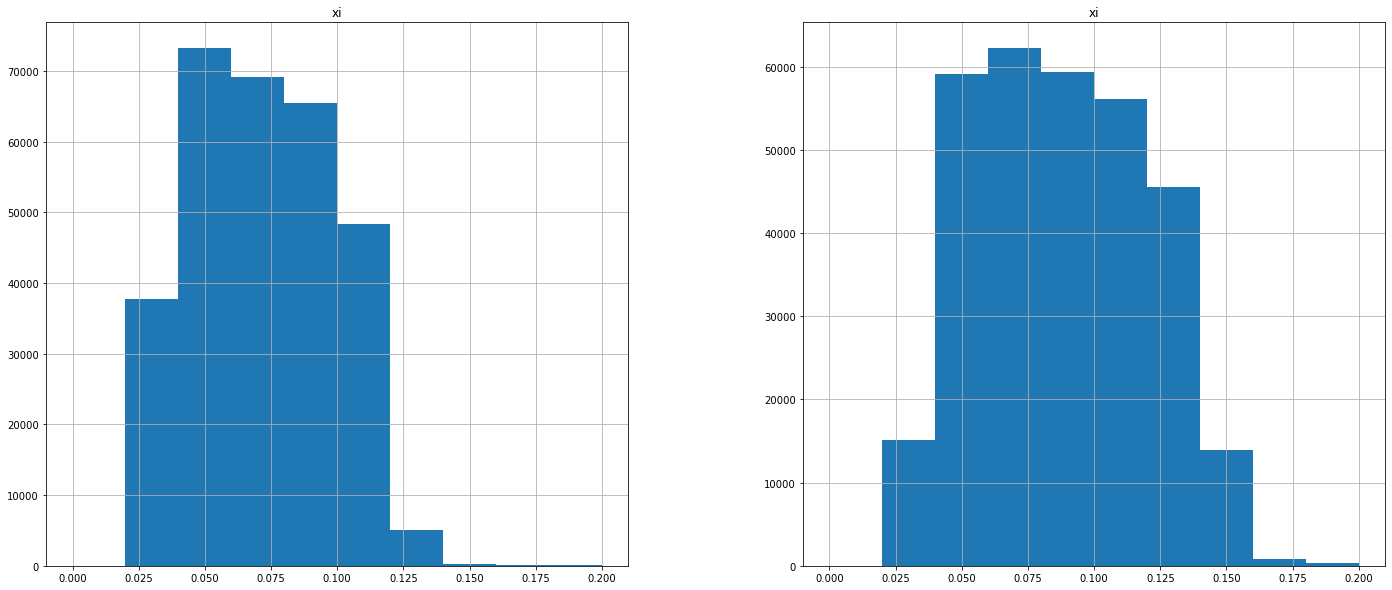

In [14]:
fig, axes = plt.subplots( 1, 2, figsize=(24,10) )
df_protons_multiRP[ df_protons_multiRP.arm == 0 ].hist( "xi", bins=10, range=(0.,0.2), ax=axes[0] )
df_protons_multiRP[ df_protons_multiRP.arm == 1 ].hist( "xi", bins=10, range=(0.,0.2), ax=axes[1] )

In [ ]:
df_protons_multiRP_events = df_protons_multiRP_index.drop( columns=[ "xi", "thx", "thy", "t", "ismultirp", "rpid", "arm" ] )
df_protons_multiRP_events = df_protons_multiRP_events[ ~df_protons_multiRP_events.index.duplicated(keep='first') ]
df_protons_multiRP_events

In [ ]:
fig, axes = plt.subplots( 1, 2, figsize=(24,10) )
df_protons_multiRP_events.hist( "recoMWW", bins=50, range=(200.,2000.), ax=axes[0] )
df_protons_multiRP_events.hist( "recoRapidityWW", bins=50, range=(-3.,3.), ax=axes[1] )

In [ ]:
#list( df_protons_multiRP_index.groupby( ["run","lumiblock","event","slice"] ) )
#df_protons_multiRP_index.groupby( ["run","lumiblock","event","slice"] ).apply( lambda df_: print( df_.iloc[0].xi, df_.iloc[1].xi ) )
df_protons_multiRP_events_groupby = df_protons_multiRP_index[ ["xi"] ].groupby( ["run","lumiblock","event","slice"] )
df_protons_multiRP_events[ "MX" ] = df_protons_multiRP_events_groupby.apply( lambda df_: 13000. * np.sqrt( df_.iloc[0].xi * df_.iloc[1].xi ) )
df_protons_multiRP_events[ "YX" ] = df_protons_multiRP_events_groupby.apply( lambda df_: 0.5 * np.log( df_.iloc[0].xi / df_.iloc[1].xi ) )
df_protons_multiRP_events[ "diffMWW_MX" ]  = df_protons_multiRP_events[ "recoMWW" ] - df_protons_multiRP_events[ "MX" ]
df_protons_multiRP_events[ "ratioMWW_MX" ] = df_protons_multiRP_events[ "recoMWW" ] / df_protons_multiRP_events[ "MX" ]
df_protons_multiRP_events[ "diffYWW_YX" ]  = df_protons_multiRP_events[ "recoRapidityWW" ] - df_protons_multiRP_events[ "YX" ]
df_protons_multiRP_events

In [ ]:
fig, axes = plt.subplots( 1, 2, figsize=(24,10) )
df_protons_multiRP_events.hist( "MX", bins=50, range=(200.,2000.), ax=axes[0] )
df_protons_multiRP_events.hist( "YX", bins=50, range=(-3.,3.), ax=axes[1] )

In [ ]:
fig, axes = plt.subplots( 1, 2, figsize=(24,10) )
df_protons_multiRP_events.hist( "diffMWW_MX", bins=50, range=(-1000.,1000.), ax=axes[0] )
df_protons_multiRP_events.hist( "diffYWW_YX", bins=50, range=(-3.,3.), ax=axes[1] )

In [ ]:
df_protons_multiRP_events.hist( "ratioMWW_MX", bins=50, range=(0.,1.5), figsize=(12,10) )

In [ ]:
fig = plt.figure( figsize=(12,10) )
plt.plot( (0.,2.), (0.,0.), color='lightblue' )
plt.plot( (1.,1.), (-3.,3.), color='lightblue' )
ax = plt.gca()
df_protons_multiRP_events.plot( "ratioMWW_MX", "diffYWW_YX", 'scatter', ax=ax )
plt.xlim(0., 2.0)
plt.ylim(-3., 3.)

In [ ]:
df_protons_singleRP

In [ ]:
df_protons_singleRP_index = df_protons_singleRP.set_index( ['run', 'lumiblock', 'event', 'slice'] )
df_protons_singleRP_index

In [ ]:
df_ppstracks

In [ ]:
df_ppstracks_index = df_ppstracks.set_index( ['run', 'lumiblock', 'event', 'slice'] )
#df_ppstracks_index
df_ppstracks_index[ ( df_ppstracks_index.rpid != 16 ) & ( df_ppstracks_index.rpid != 116 ) ]

In [ ]:
fig, axes = plt.subplots( 1, 2, figsize=(24,10) )
df_ppstracks[ df_ppstracks.rpid == 23 ].hist( "x", bins=40, range=(0.,80.), ax=axes[0] )
df_ppstracks[ df_ppstracks.rpid == 23 ].hist( "y", bins=20, range=(-15.,15.), ax=axes[1] )

### References

In [ ]:
np.info( ak.concatenate )

In [ ]:
np.info( pd.DataFrame.hist )

In [ ]:
np.info( pd.DataFrame.plot.scatter )

In [ ]:
np.info( plt.plot )